In [1]:
import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from typing import List, Dict, Union, Tuple, Optional, Any
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from preproc_util import (
    emotion_eprime_preproc,
    wm_eprime_preproc,
    language_eprime_preproc,
    relation_eprime_preproc,
    social_eprime_preproc,
    gamble_eprime_preproc,
    motor_eprime_preproc
)

In [3]:
hcp_eprime_folder = "/home/feczk001/mdemiden/data/hcp_eprime/HCP_1200"
# 0 = emotion , 1 = gambling, 2= language, 3 = motor, 4= relatonal, 5=social, 6 =wm
task_names = ['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']
runs = {
    "LR": "run2",
    "RL": "run1"
}

In [4]:
hcp_eprime_folder = "/home/feczk001/mdemiden/data/hcp_eprime/HCP_1200"
# 0 = emotion , 1 = gambling, 2= language, 3 = motor, 4= relatonal, 5=social, 6 =wm
task_names = ['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']
runs = {
    "LR": "run2",
    "RL": "run1"
}


## Single Sub Test

In [ ]:
task_name = 'GAMBLING'
subject = 'TESTID'
run_num = 'run1'
files = sorted(Path(hcp_eprime_folder).rglob(f"{subject}_3T_{task_name}_{run_num}_TAB.txt"))


In [ ]:
eprime_df = pd.read_csv(files[0], sep='\t')
gamble_eprime_preproc(eprime_df)

## Full Run

In [ ]:
hcp_eprime_folder = "/home/feczk001/mdemiden/data/hcp_eprime/HCP_1200"
output_dir = "/home/feczk001/mdemiden/data/hcp_events"
session = "ses-3T"
task_names = ['GAMBLING'] #['EMOTION', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM', 'GAMBLING', 'LANGUAGE']
runs = {
    "LR": 2,
    "RL": 1
}


# Function to process each subject
def process_subject(sub_file, task_name, dir_label,run_num, output_name):
    subject = sub_file.parts[7] 
    print(f"Starting subject sub-{subject}")
    events_file = pd.read_csv(sub_file, sep='\t')
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_name):
        os.makedirs(output_name)
    
    # Preprocess data for each task
    if task_name == 'EMOTION':
        converted_df = emotion_eprime_preproc(events_file)
    elif task_name == 'GAMBLING':
        converted_df = gamble_eprime_preproc(events_file)
    elif task_name == 'LANGUAGE':
        converted_df = language_eprime_preproc(events_file)
    elif task_name == 'MOTOR':
        converted_df = motor_eprime_preproc(events_file)
    elif task_name == 'RELATIONAL':
        converted_df = relation_eprime_preproc(events_file)
    elif task_name == 'SOCIAL':
        converted_df = social_eprime_preproc(events_file)
    elif task_name == 'WM':
        converted_df = wm_eprime_preproc(events_file)

    # Export the processed dataframe
    file_name = f"{output_name}/sub-{subject}_{session}_task-{task_name.lower()}_dir-{dir_label}_run-{run_num}_events.tsv"
    converted_df.to_csv(file_name, sep="\t")
    print(f"Processed file saved: {file_name}")

# Loop through subjects and tasks
for task_name in task_names:
    print(f"{task_name}")
    for dir_label, run_num in runs.items():
        files = sorted(Path(hcp_eprime_folder).rglob(f"*_3T_{task_name}_run{run_num}_TAB.txt"))
        print(f"   running over {len(files)} subject files")
        for sub_file in files:
            output_name = f"{output_dir}/sub-{sub_file.parts[7]}/{session}/func"
            print(output_name)
            process_subject(sub_file, task_name, dir_label, run_num, output_name)

# Summarizing events

In [6]:
# Descriptives of Behavioral Data
events_folder = '/home/feczk001/mdemiden/data/hcp_events'
out_figs = '/home/feczk001/mdemiden/slurm_ABCD_s3/hcpya_preprocess/scripts/taskevents/imgs'

## Emotion task Distributions

In [6]:
task = 'emotion'
run = 'run-1'

files = sorted(Path(events_folder).rglob(f"sub-*_ses-3T_task-{task}_dir-*_{run}_events.tsv"))
combined = []
for sub_file in files:
    subject = sub_file.parts[-4]    
    out = pd.read_csv(sub_file, sep='\t')
    combined.append((subject, out))  # Append tuple of subject ID and processed dataframe
emotion_df = pd.concat([df.assign(subject=subject) for subject, df in combined], ignore_index=True)
print("Rows in final Df:", len(emotion_df), "for unique subjects:", len(emotion_df['subject'].unique()))

Rows in final Df: 81744 for unique subjects: 1048


The [Barch et al. (2013, pg 178-179)](https://www.sciencedirect.com/science/article/pii/S1053811913005272) highlights the Emotion Task as:

"Emotion processing. This task was adapted from the one developed by Hariri and colleagues which had shown evidence as a functional localizer (Hariri et al., 2002) with moderate reliability across time  Group Analysis Task Activation Maps. The participants are presented with blocks of trials that ask them to decide either which of two faces presented on the bottom of the screen match the face at the top of the screen, or which of two shapes presented at the bottom of the screen match the shape at the top of the screen. The faces have either angry or fearful expressions. *Trials are presented in blocks of 6 trials of the same task (face or shape), with the stimulus presented for 2 s and a 1 s ITI. Each block is preceded by a 3 s task cue (“shape” or “face”), so that each block is 21 s including the cue.* Each of the two runs includes *3 face blocks and 3 shape blocks*. However, there was a **bug in the E-prime script for this task such that the task stopped short of the last three trials of the last task block in each run**. To promote comparability across the participants, we decided not to fix the bug (given that a number of subjects had already been run before it was detected) as we thought it would have minimal impact on the data. In phase I, we compared this task to one using negative and neutral IAPS pictures (see the Supplemental materials)."

### Distribution of First/Last Onset Time

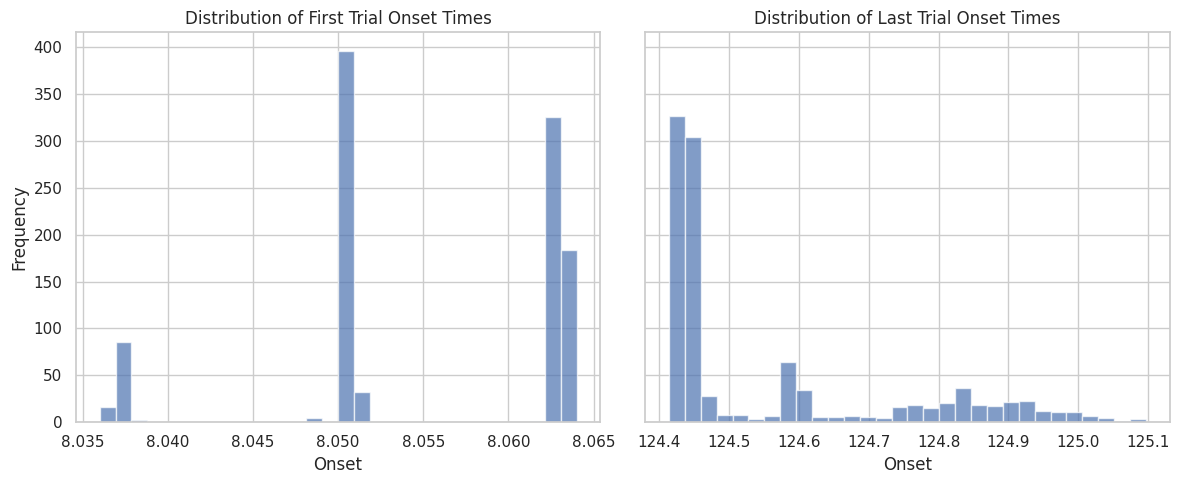

In [22]:
onset_times = emotion_df.groupby("subject")["onset"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Onset Times")
axes[0].set_xlabel("Onset")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Onset Times")
axes[1].set_xlabel("Onset")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstonset.png", dpi=300, bbox_inches='tight')
plt.show()

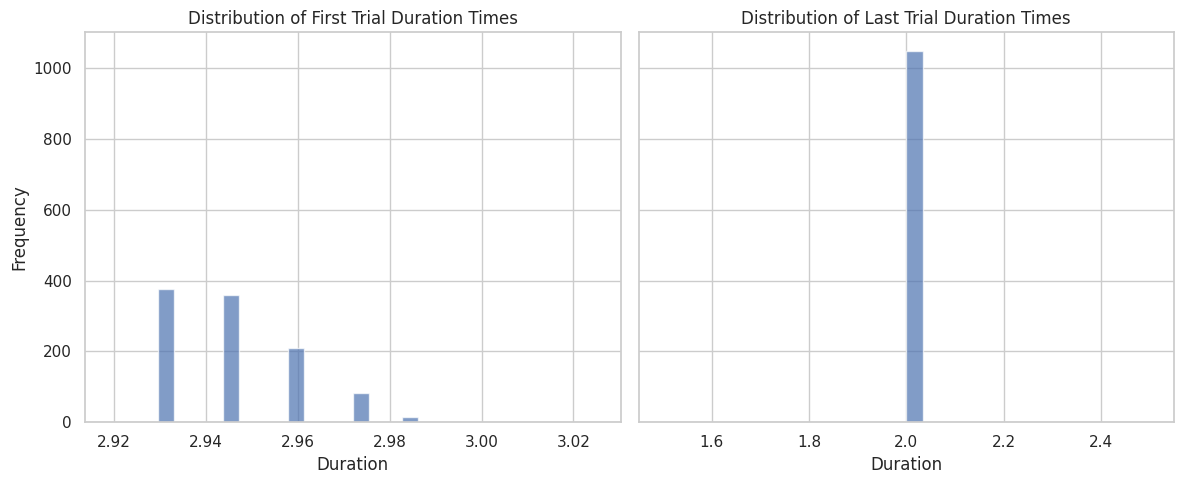

In [23]:
onset_times = emotion_df.groupby("subject")["duration"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Duration Times")
axes[0].set_xlabel("Duration")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Duration Times")
axes[1].set_xlabel("Duration")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstduration.png", dpi=300, bbox_inches='tight')
plt.show()

### Distribution of `Durations`

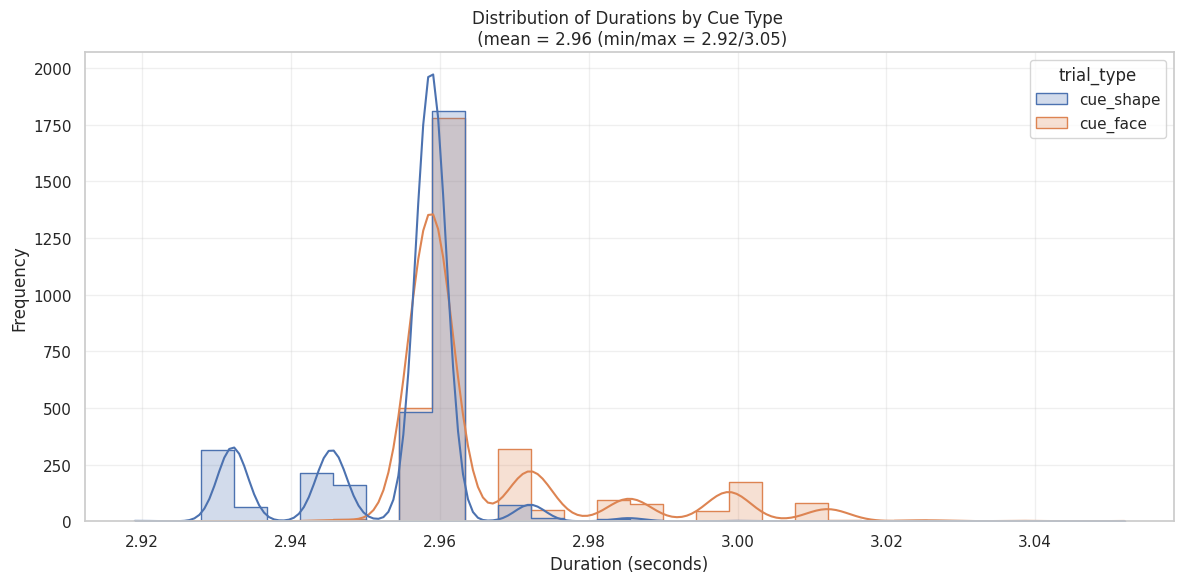

In [24]:
cue_trials = emotion_df[emotion_df['trial_type'].str.contains('cue', case=False)]


duration_mean = np.round(cue_trials['duration'].mean(),2)
duration_min = np.round(cue_trials['duration'].min(),2)
duration_max = np.round(cue_trials['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=cue_trials, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations by Cue Type \n (mean = {duration_mean} (min/max = {duration_min}/{duration_max})")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-cuedurations.png", dpi=300, bbox_inches='tight')
plt.show()


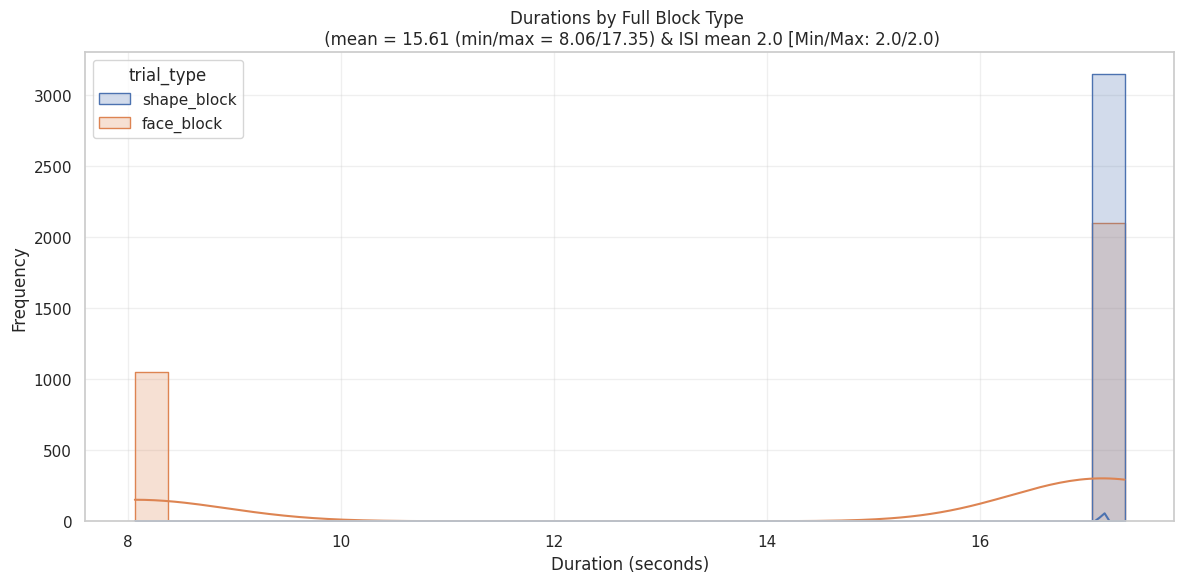

In [25]:
fullblk_trials = emotion_df[emotion_df['trial_type'].str.contains('block', case=False)]
plt.figure(figsize=(12, 6))
sns.histplot(data=fullblk_trials, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins

duration_mean = np.round(fullblk_trials['duration'].mean(),2)
duration_min = np.round(fullblk_trials['duration'].min(),2)
duration_max = np.round(fullblk_trials['duration'].max(),2)

plt.title(f"Durations by Full Block Type \n (mean = {duration_mean} (min/max = {duration_min}/{duration_max}) & ISI mean {avg_isi} [Min/Max: {min_isi}/{max_isi})")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fullblockdurations.png", dpi=300, bbox_inches='tight')
plt.show()


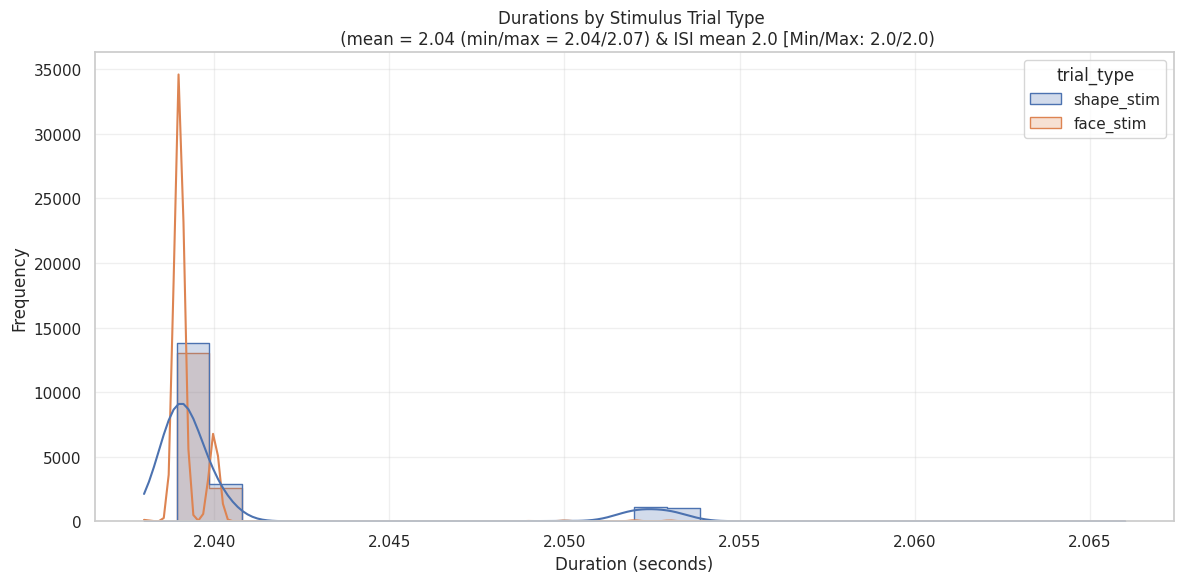

In [26]:
stimulus_trials = emotion_df[emotion_df['trial_type'].str.contains('stim', case=False)]
isi_trials = emotion_df[emotion_df['trial_type'].str.contains('isi', case=False)]
avg_isi = isi_trials['duration'].mean()
min_isi = isi_trials['duration'].min()
max_isi = isi_trials['duration'].max()
duration_mean = np.round(stimulus_trials['duration'].mean(),2)
duration_min = np.round(stimulus_trials['duration'].min(),2)
duration_max = np.round(stimulus_trials['duration'].max(),2)
plt.figure(figsize=(12, 6))
sns.histplot(data=stimulus_trials, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins

plt.title(f"Durations by Stimulus Trial Type \n (mean = {duration_mean} (min/max = {duration_min}/{duration_max}) & ISI mean {avg_isi} [Min/Max: {min_isi}/{max_isi})")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-stimulusdurations.png", dpi=300, bbox_inches='tight')
plt.show()


"there was a **bug in the E-prime script for this task such that the task stopped short of the last three trials of the last task block in each run**.".
The distribution below suggests that this is limited to the `Faces`. As the last and third block for Shapes is consistent with the others.

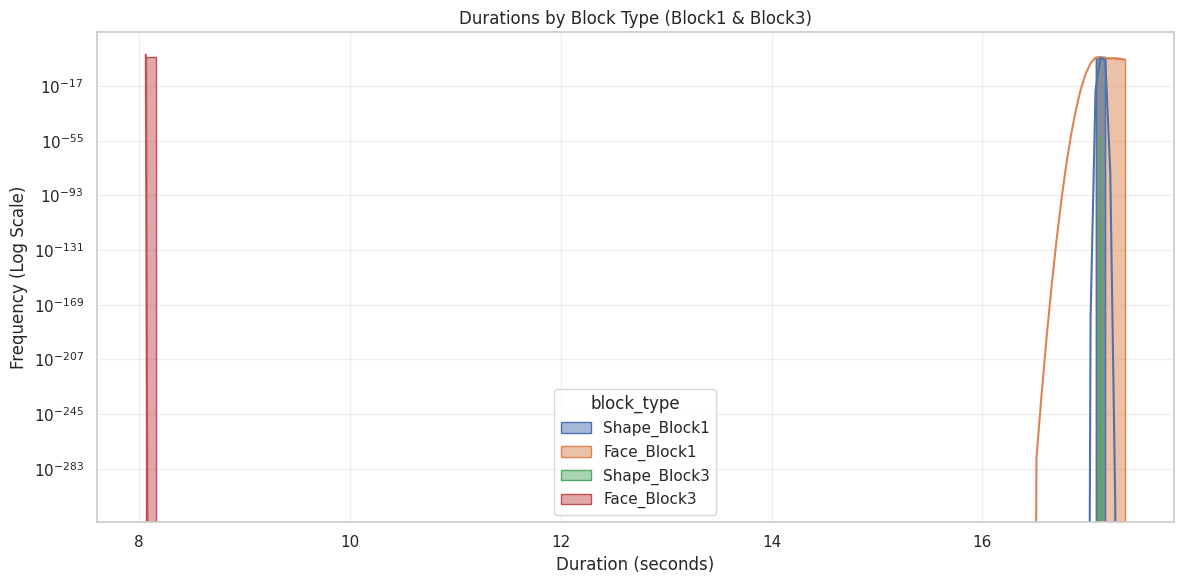

In [27]:
plt.figure(figsize=(12, 6))

# Filter data to include only Block1 and Block3
blocktype = emotion_df[
    emotion_df['block_type'].str.contains('Block1|Block3', case=False, na=False) & 
    emotion_df['trial_type'].str.contains('block', case=False, na=False)
]

sns.histplot(data=blocktype, x='duration', hue='block_type', kde=True, element='step',
             bins=100, alpha=0.5, multiple="layer") 

plt.yscale("log")  # Log scale to better see differences
plt.title("Durations by Block Type (Block1 & Block3)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency (Log Scale)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-blocktypedurations.png", dpi=300, bbox_inches='tight')
plt.show()


### `Responses` Times across Stimulus Type

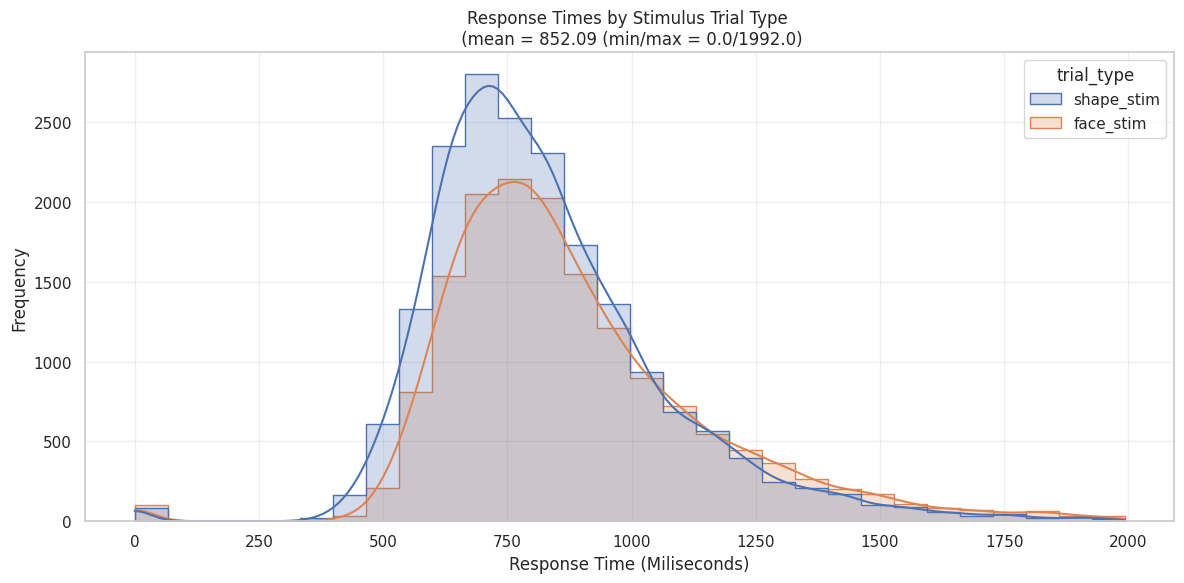

In [31]:
stimulus_trials = emotion_df[emotion_df['trial_type'].str.contains('stim', case=False)]
plt.figure(figsize=(12, 6))
sns.histplot(data=stimulus_trials, x='response_time', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins

resp_mean = np.round(stimulus_trials['response_time'].mean(),2)
resp_min = np.round(stimulus_trials['response_time'].min(),2)
resp_max = np.round(stimulus_trials['response_time'].max(),2)

plt.title(f"Response Times by Stimulus Trial Type \n (mean = {resp_mean} (min/max = {resp_min}/{resp_max})")
plt.xlabel('Response Time (Miliseconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-rtbystimulusdist.png", dpi=300, bbox_inches='tight')
plt.show()


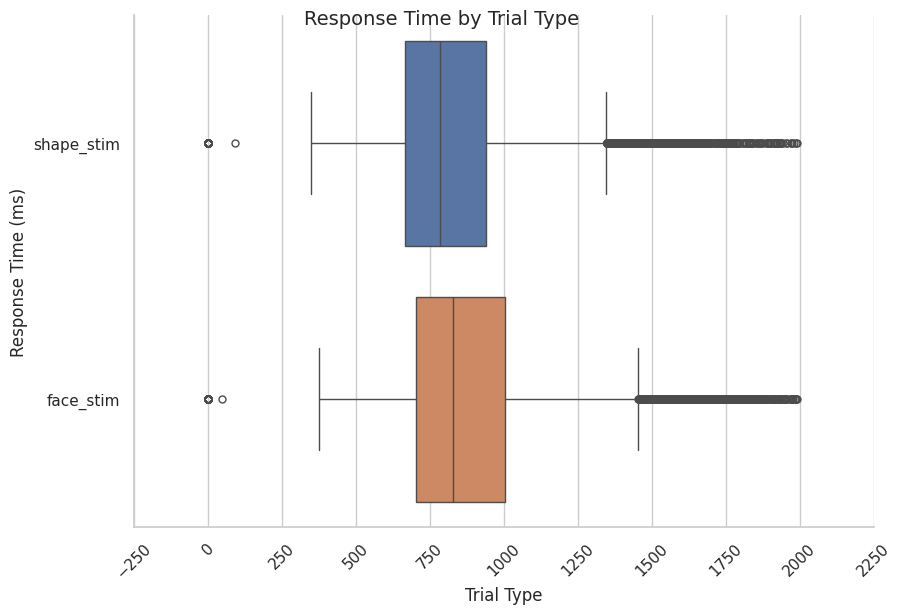

In [33]:
sns.set(style="whitegrid")

# Create the plot with facets by stim_type
g = sns.catplot(data=stimulus_trials, x="response_time", y="trial_type", hue="trial_type", kind="box", height=6, aspect=1.5)

# Label the axes
g.set_axis_labels("Trial Type", "Response Time (ms)")

# Title for the entire plot
g.fig.suptitle("Response Time by Trial Type", fontsize=14)

# Rotate x-axis labels if necessary
g.set_xticklabels(rotation=45)

# Show the plot
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-rtbystimulushist.png", dpi=300, bbox_inches='tight')
plt.show()


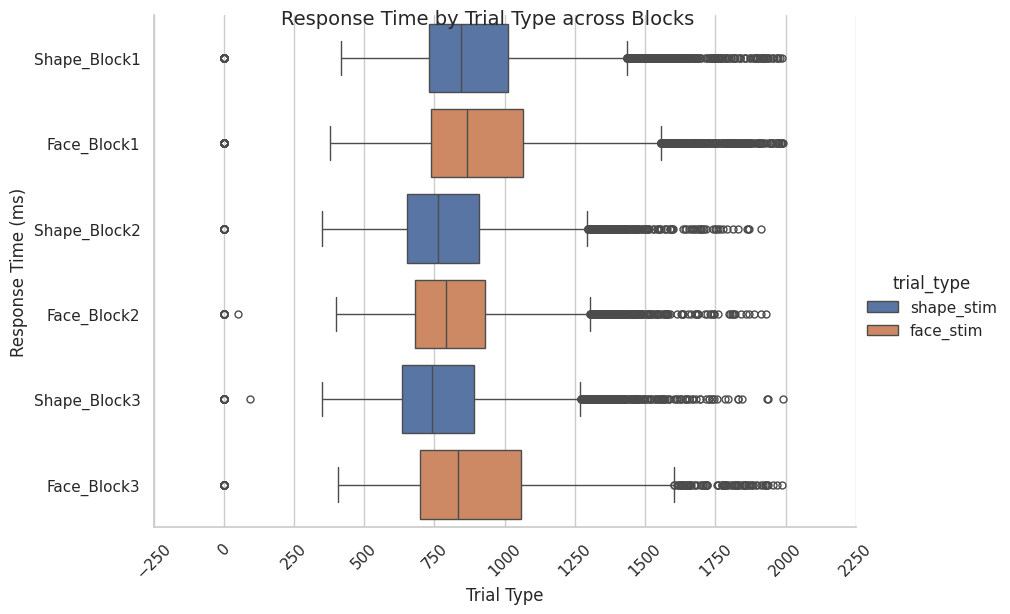

In [30]:
sns.set(style="whitegrid")

# Create the plot with facets by stim_type
g = sns.catplot(data=stimulus_trials, x="response_time", y="block_type", hue="trial_type", kind="box", height=6, aspect=1.5)

# Label the axes
g.set_axis_labels("Trial Type", "Response Time (ms)")

# Title for the entire plot
g.fig.suptitle("Response Time by Trial Type across Blocks", fontsize=14)

# Rotate x-axis labels if necessary
g.set_xticklabels(rotation=45)

# Show the plot
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-rtbyblockdist.png", dpi=300, bbox_inches='tight')
plt.show()


## Gambling

The [Barch et al. (2013, pg 177)](https://www.sciencedirect.com/science/article/pii/S1053811913005272) highlights the Gambling Task as:

"Incentive processing. This task was adapted from the one developed by Delgado et al. (2000), and was chosen based on prior evidence that the task elicits activations in the striatum and other reward related regions that are robust and reliable across the subjects (Delgado et al., 2000; Forbes et al., 2009; May et al., 2004; Tricomi et al., 2004). The participants play a card guessing game where they are asked to guess the number on a mystery card (represented by a “?”) in order to win or lose money. They are told that potential card numbers range from 1 to 9 and to indicate if they think the mystery card number is more or less than 5 by pressing one of two buttons on the  response box. Feedback is the number on the card (generated by the program as a function of whether the trial was a reward, loss or neutral trial) and either: 1) a green up arrow with `$1` for reward trials, 2) a red down arrow next to − `$0.50` for loss trials; or 3) the number 5 and a gray double headed arrow for neutral trials. The “?” is presented for up to 1.5 s (if the participant responds before 1.5 s, a fixation cross is displayed for the remaining time), following by feedback for 1.0 s. There is a 1.0 s ITI with a “+” presented on the screen. The task is presented in blocks of 8 trials that are either mostly reward (6 reward trials pseudo randomly interleaved with either 1 neutral and 1 loss trial, 2 neutral trials, or 2 loss trials) or mostly loss (6 loss trials interleaved with either 1 neutral and 1 reward trial, 2 neutral trials, or 2 reward trials). In each of the two runs, there are 2 mostly reward and 2 mostly loss blocks, interleaved with 4 fixation blocks (15 s each). All the participants are provided with money as a result of completing the task, though it is a standard amount across subjects."

In [21]:
task = 'gambling'
run = 'run-1'

files = sorted(Path(events_folder).rglob(f"sub-*_ses-3T_task-{task}_dir-*_{run}_events.tsv"))
combined = []
for sub_file in files:
    subject = sub_file.parts[-4]    
    out = pd.read_csv(sub_file, sep='\t')
    combined.append((subject, out))  # Append tuple of subject ID and processed dataframe
gambling_df = pd.concat([df.assign(subject=subject) for subject, df in combined], ignore_index=True)
print("Rows in final Df:", len(gambling_df), "for unique subjects:", len(gambling_df['subject'].unique()))

Rows in final Df: 147152 for unique subjects: 1082


### Distribution of First/Last Onset Time & Duration

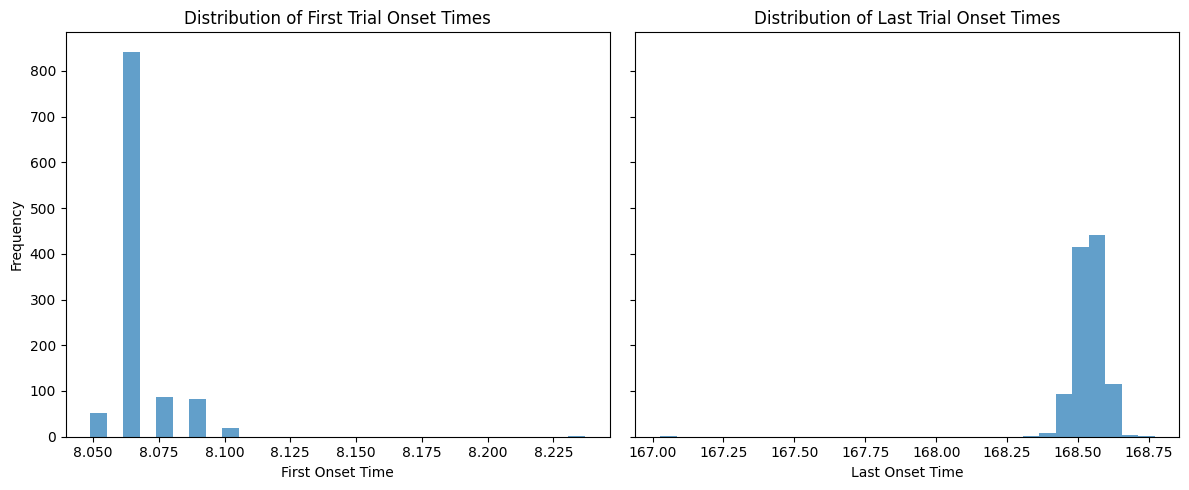

In [22]:
onset_times = gambling_df.groupby("subject")["onset"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Onset Times")
axes[0].set_xlabel("First Onset Time")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Onset Times")
axes[1].set_xlabel("Last Onset Time")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstonsets", dpi=300, bbox_inches='tight')
plt.show()

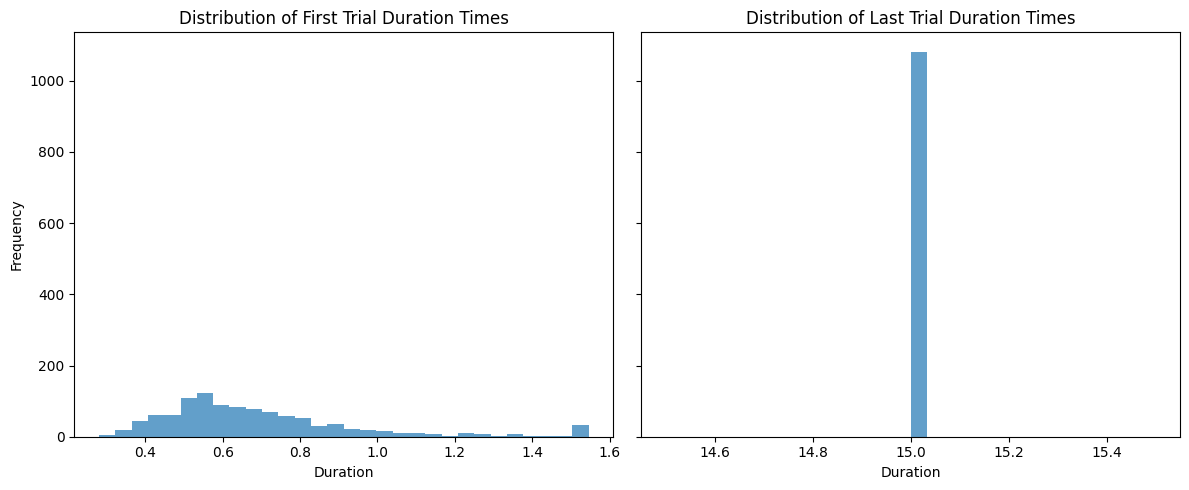

In [9]:
onset_times = gambling_df.groupby("subject")["duration"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Duration Times")
axes[0].set_xlabel("Duration")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Duration Times")
axes[1].set_xlabel("Duration")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstdurations", dpi=300, bbox_inches='tight')

plt.show()

In [10]:
questmark_trials = gambling_df[gambling_df['trial_type'].str.contains('quest_mark', case=False)]

questmark_trials.sort_values(by='duration', ascending=True)


,Unnamed: 0,onset,duration,trial_type,reward_type,response_time,accuracy,response,feedback_type,block,mostly_reward,mostly_punish,subject
45982,14,18.899,0.000,quest_mark,Reward,0.0,0.0,2.0,NaN,Gamble_Block1,1.0,0.0,sub-168745
102802,122,157.722,0.066,quest_mark,Reward,5.0,0.0,2.0,NaN,Gamble_Block4,1.0,0.0,sub-524135
13579,115,150.459,0.067,quest_mark,Reward,4.0,0.0,3.0,NaN,Gamble_Block4,1.0,0.0,sub-120010
135597,5,11.675,0.067,quest_mark,Reward,13.0,0.0,3.0,NaN,Gamble_Block1,1.0,0.0,sub-867468
75611,131,164.973,0.067,quest_mark,Reward,6.0,0.0,3.0,NaN,Gamble_Block4,1.0,0.0,sub-214524
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144242,82,110.195,1.547,quest_mark,Punishment,0.0,1.0,NaN,NaN,Gamble_Block3,0.0,1.0,sub-965771
143747,131,164.986,1.559,quest_mark,Reward,1491.0,0.0,3.0,NaN,Gamble_Block4,1.0,0.0,sub-958976
114031,63,77.196,1.559,quest_mark,Punishment,1496.0,0.0,2.0,NaN,Gamble_Block2,0.0,1.0,sub-623137
128371,123,157.762,1.559,quest_mark,Reward,1484.0,0.0,2.0,NaN,Gamble_Block4,1.0,0.0,sub-779370


### Distribution of `Durations`

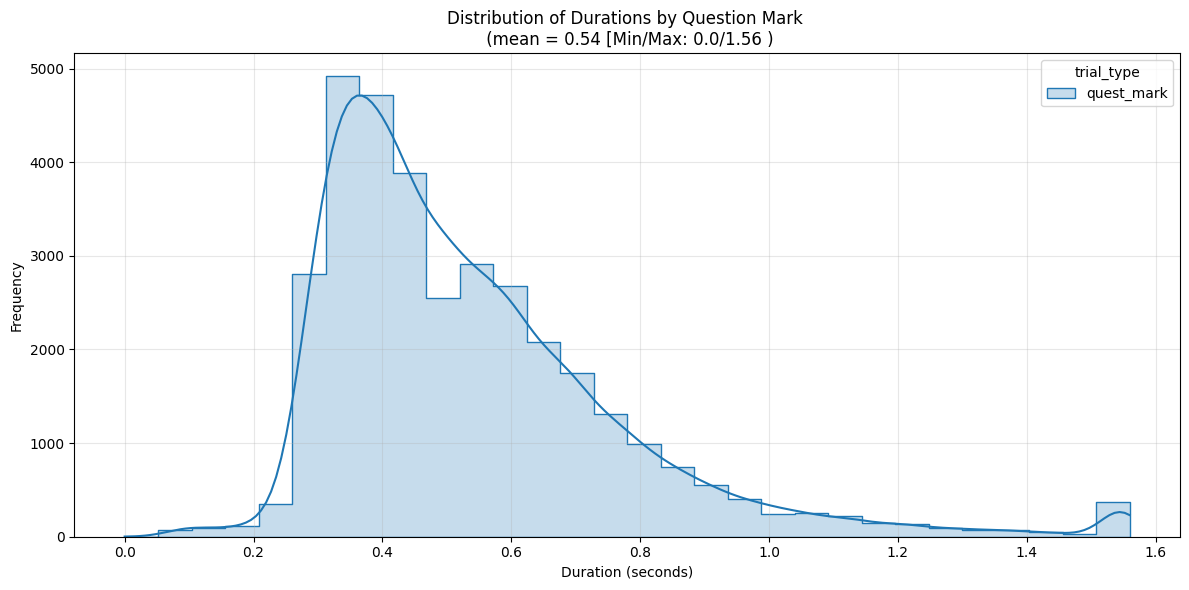

In [26]:
questmark_trials = gambling_df[gambling_df['trial_type'].str.contains('quest_mark', case=False)]

duration_mean = np.round(questmark_trials['duration'].mean(),2)
duration_min = np.round(questmark_trials['duration'].min(),2)
duration_max = np.round(questmark_trials['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=questmark_trials, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations by Question Mark \n (mean = {duration_mean} [Min/Max: {duration_min}/{duration_max} )")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-qmarkdurs", dpi=300, bbox_inches='tight')
plt.show()

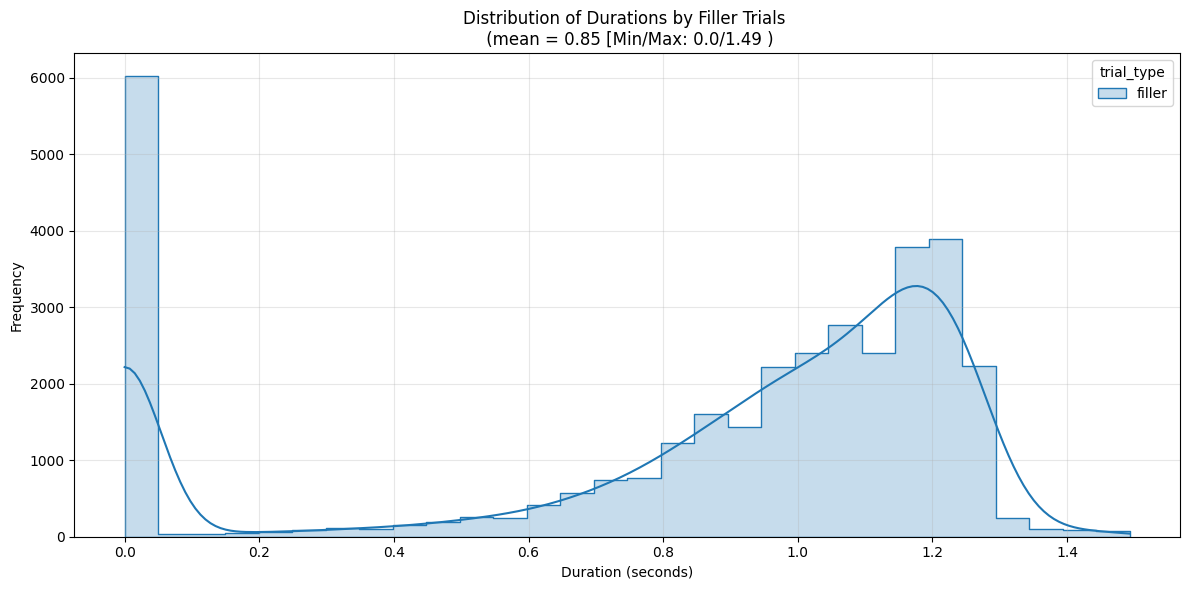

In [24]:
filler_trials = gambling_df[gambling_df['trial_type'].str.contains('filler', case=False)]

duration_mean = np.round(filler_trials['duration'].mean(),2)
duration_min = np.round(filler_trials['duration'].min(),2)
duration_max = np.round(filler_trials['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=filler_trials, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations by Filler Trials \n (mean = {duration_mean} [Min/Max: {duration_min}/{duration_max} )")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fillerdurs", dpi=300, bbox_inches='tight')

plt.show()

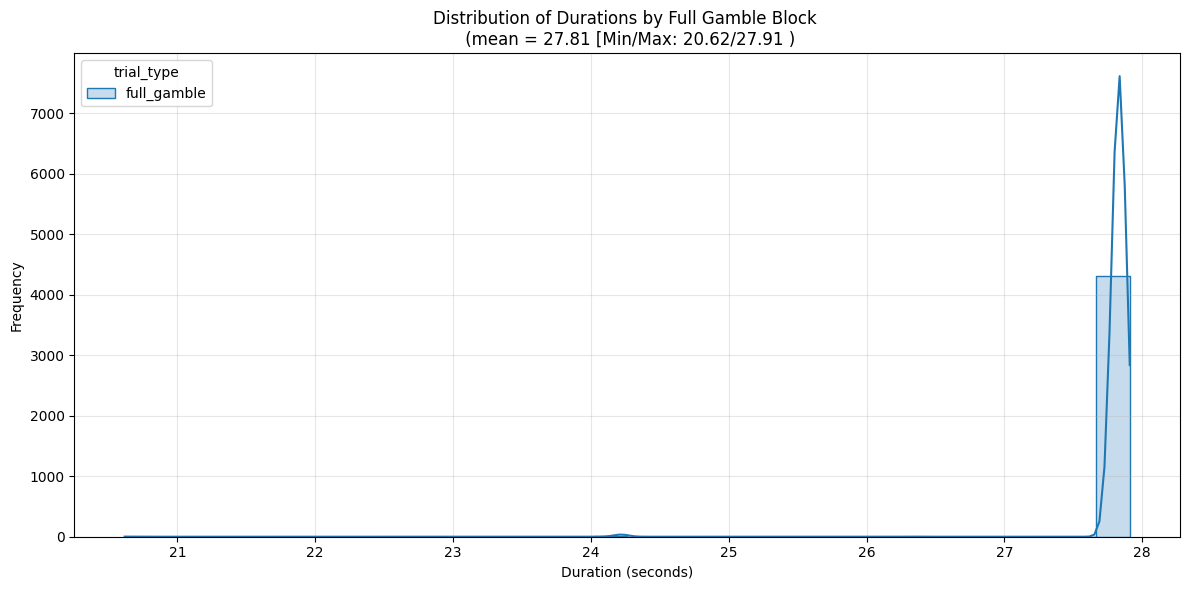

In [13]:
full_gamble_dur = gambling_df[gambling_df['trial_type'].str.contains('full', case=False)]

duration_mean = np.round(full_gamble_dur['duration'].mean(),2)
duration_min = np.round(full_gamble_dur['duration'].min(),2)
duration_max = np.round(full_gamble_dur['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=full_gamble_dur, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations by Full Gamble Block \n (mean = {duration_mean} [Min/Max: {duration_min}/{duration_max} )")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fullblockdur", dpi=300, bbox_inches='tight')

plt.show()

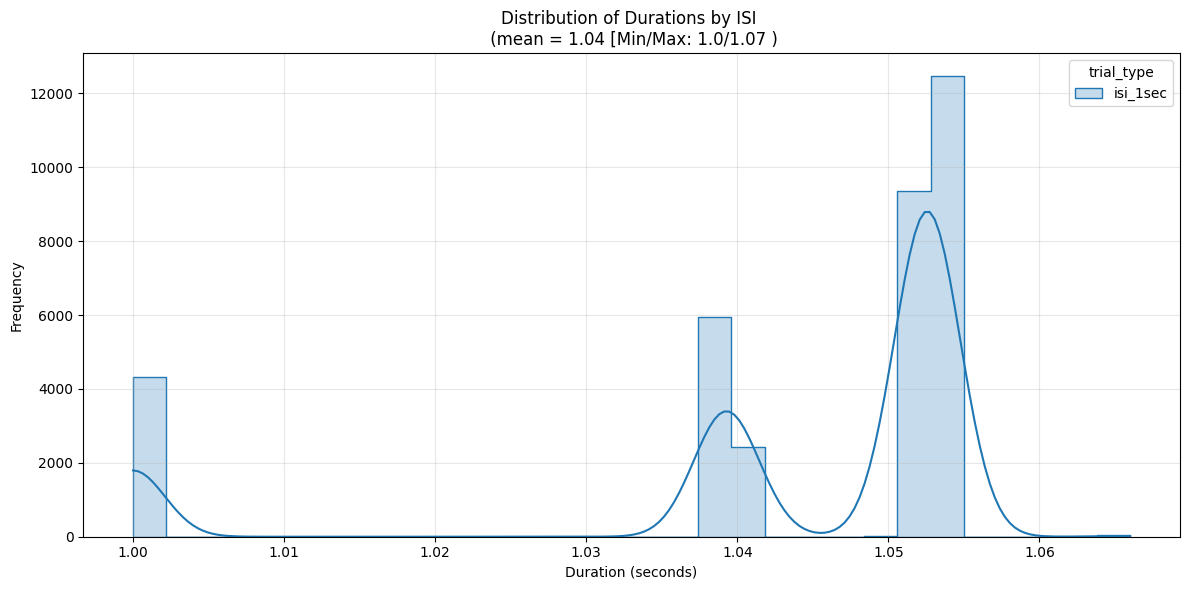

In [14]:
# Note, some ISIs are defered to the default 1000ms when next row is empty and unable to calculate (i.e., onsettoonset not informative)
isi_dur = gambling_df[gambling_df['trial_type'].str.contains('isi', case=False)]

duration_mean = np.round(isi_dur['duration'].mean(),2)
duration_min = np.round(isi_dur['duration'].min(),2)
duration_max = np.round(isi_dur['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=isi_dur, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations by ISI \n (mean = {duration_mean} [Min/Max: {duration_min}/{duration_max} )")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-isidura.png", dpi=300, bbox_inches='tight')

plt.show()

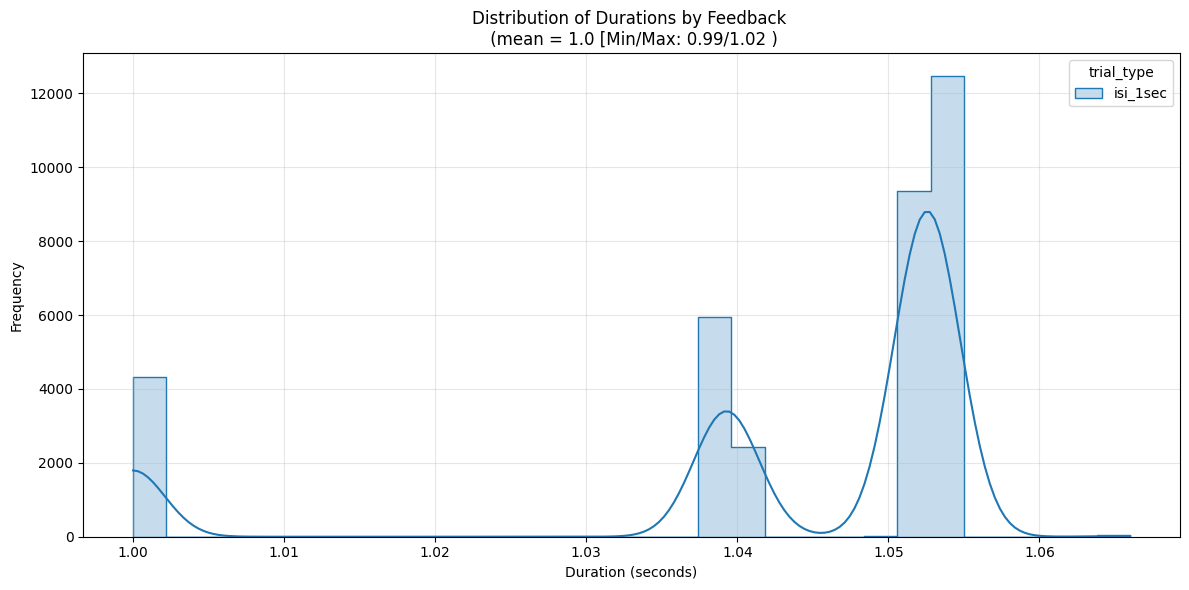

In [15]:
# Note, some Feedback Durations are defered to the default 1000ms when next row is empty and unable to calculate (i.e., onsettoonset not informative)

fb_dur = gambling_df[gambling_df['trial_type'].str.contains('feedback', case=False)]

duration_mean = np.round(fb_dur['duration'].mean(),2)
duration_min = np.round(fb_dur['duration'].min(),2)
duration_max = np.round(fb_dur['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=isi_dur, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations by Feedback \n (mean = {duration_mean} [Min/Max: {duration_min}/{duration_max} )")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-feedbackduration.png", dpi=300, bbox_inches='tight')

plt.show()

### Response times

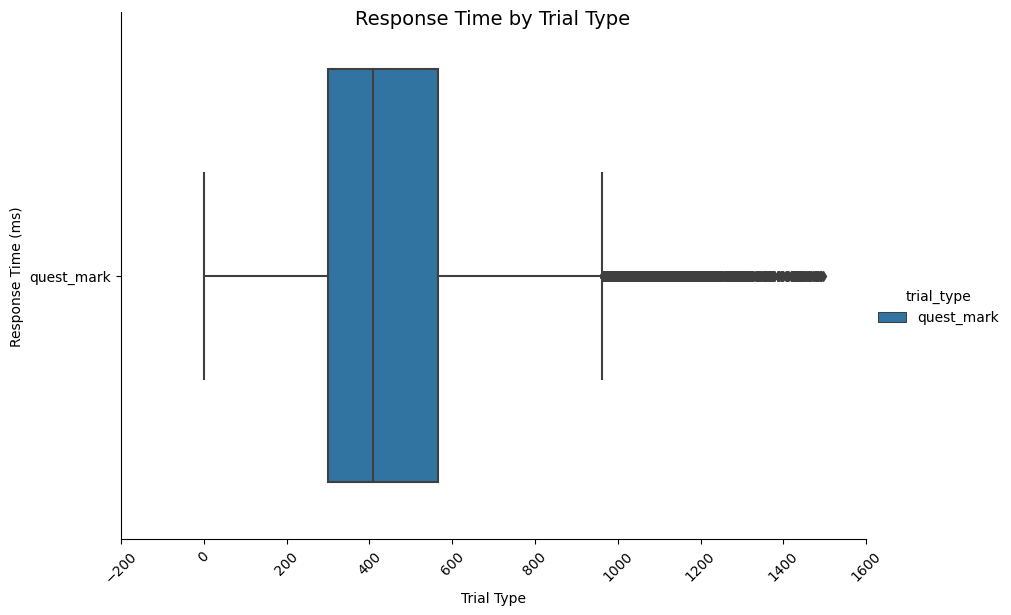

In [16]:
# Create the plot with facets by stim_type
g = sns.catplot(data=questmark_trials, x="response_time", y="trial_type", hue="trial_type", kind="box", height=6, aspect=1.5)

# Label the axes
g.set_axis_labels("Trial Type", "Response Time (ms)")

# Title for the entire plot
g.fig.suptitle("Response Time by Trial Type", fontsize=14)

# Rotate x-axis labels if necessary
g.set_xticklabels(rotation=45)

# Show the plot
plt.show()

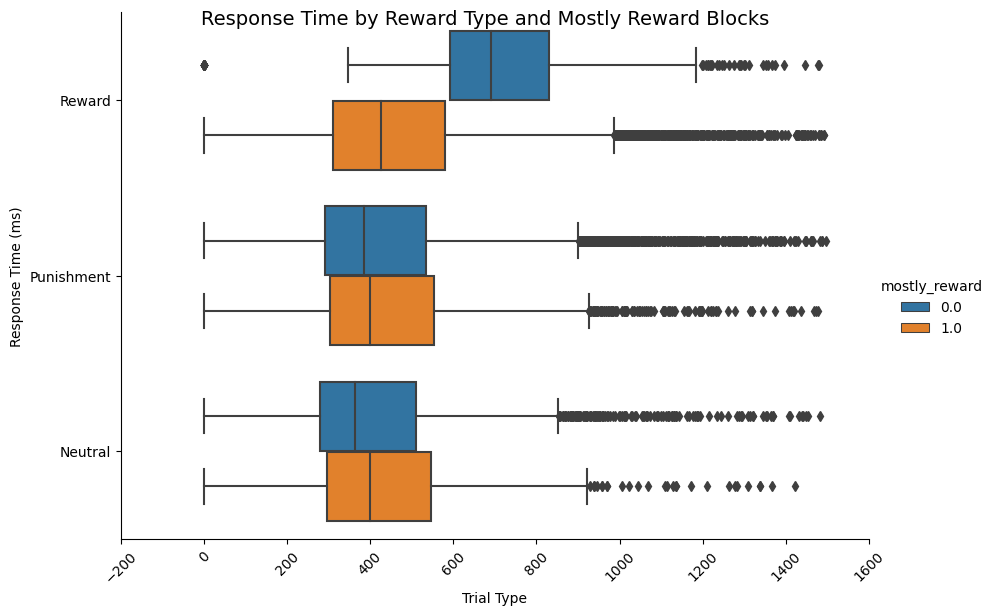

In [17]:
# Create the plot with facets by stim_type
g = sns.catplot(data=questmark_trials, x="response_time", y="reward_type", hue="mostly_reward", kind="box", height=6, aspect=1.5)

# Label the axes
g.set_axis_labels("Trial Type", "Response Time (ms)")

# Title for the entire plot
g.fig.suptitle("Response Time by Reward Type and Mostly Reward Blocks", fontsize=14)

# Rotate x-axis labels if necessary
g.set_xticklabels(rotation=45)

# Show the plot
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-responserewardtype.png", dpi=300, bbox_inches='tight')

plt.show()

## Language 

The [Barch et al. (2013, pg 177-178)](https://www.sciencedirect.com/science/article/pii/S1053811913005272) highlights the Language Task as:


"Language processing. The task being used in Phase II was developed by Binder et al. (2011) and used the E-prime scripts kindly provided by these investigators, which were then modified for our purposes. The task consists of two runs that each interleave 4 blocks of a story task and 4 blocks of a math task. As described in detail in Binder et. al. (2011), the goal of including the math blocks was to provide a comparison task that was attentionally demanding, similar in auditory and phonological input, and unlikely to generate activation of anterior temporal lobe regions involved in semantic processing, though likely to engage numerosity related processing in the parietal cortex. The lengths of the blocks vary (average of approximately 30 s), but the task was designed so that the math task blocks match the length of the story task blocks, with some additional math trials at the end of the task to complete the 3.8 min run as needed. The story blocks present participants with brief auditory stories (5–9 sentences) adapted from Aesop's fables, followed by a 2-alternative forcedchoice question that asks the participants about the topic of the story. The example provided in the original Binder paper (p. 1466) is “For example, after a story about an eagle that saves a man who had done him a favor, participants were asked, ‘That was about revenge or reciprocity?’” The math task also presents trials auditorily and requires the subjects to complete addition and subtraction problems. The trials present the subjects with a series of arithmetic operations (e.g., “Fourteen plus twelve”), followed by “equals” and then two choices (e.g., “twenty-nine or twenty-six”). The participants push a button to select either the first or the second answer. The math task is adaptive to maintain a similar level of difficulty across the participants. For more details on the task, see Binder et al. (2011)."

In [9]:
task = 'language'
run = 'run-1'

files = sorted(Path(events_folder).rglob(f"sub-*_ses-3T_task-{task}_dir-*_{run}_events.tsv"))
combined = []
for sub_file in files:
    subject = sub_file.parts[-4]    
    out = pd.read_csv(sub_file, sep='\t')
    combined.append((subject, out))  # Append tuple of subject ID and processed dataframe
language_df = pd.concat([df.assign(subject=subject) for subject, df in combined], ignore_index=True)
print("Rows in final Df:", len(language_df), "for unique subjects:", len(language_df['subject'].unique()))

Rows in final Df: 62721 for unique subjects: 1023


### Distribution of First/Last OnsetTime

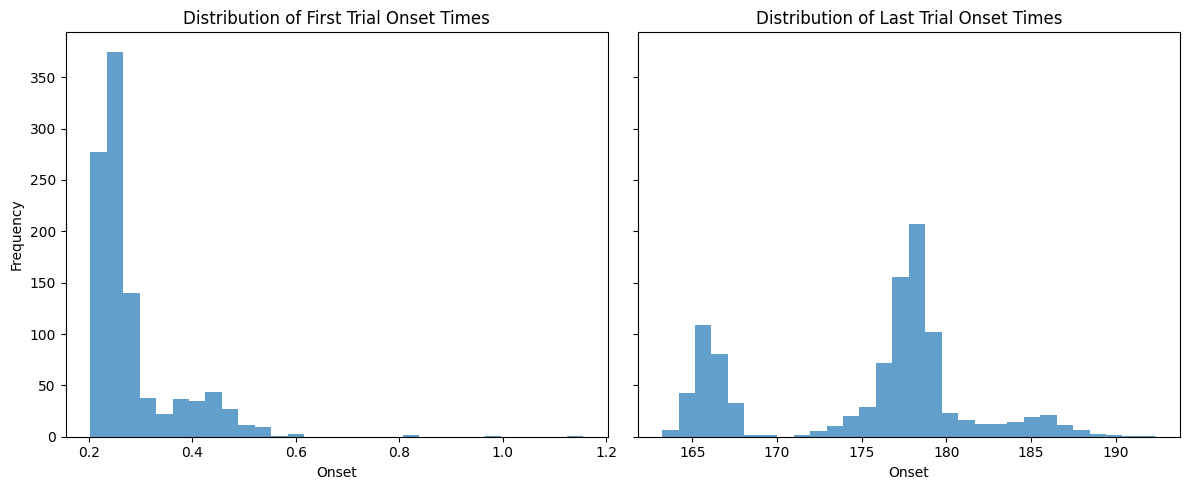

In [10]:
onset_times = language_df.groupby("subject")["onset"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Onset Times")
axes[0].set_xlabel("Onset")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Onset Times")
axes[1].set_xlabel("Onset")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstonsets.png", dpi=300, bbox_inches='tight')
plt.show()

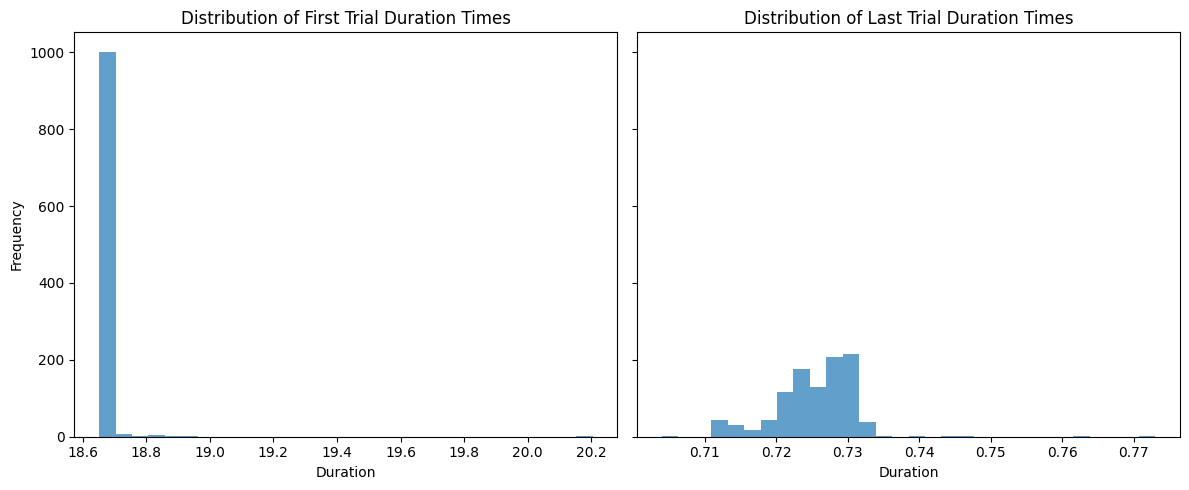

In [11]:
onset_times = language_df.groupby("subject")["duration"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Duration Times")
axes[0].set_xlabel("Duration")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Duration Times")
axes[1].set_xlabel("Duration")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstdurations.png", dpi=300, bbox_inches='tight')
plt.show()

### Distribution of `Durations`

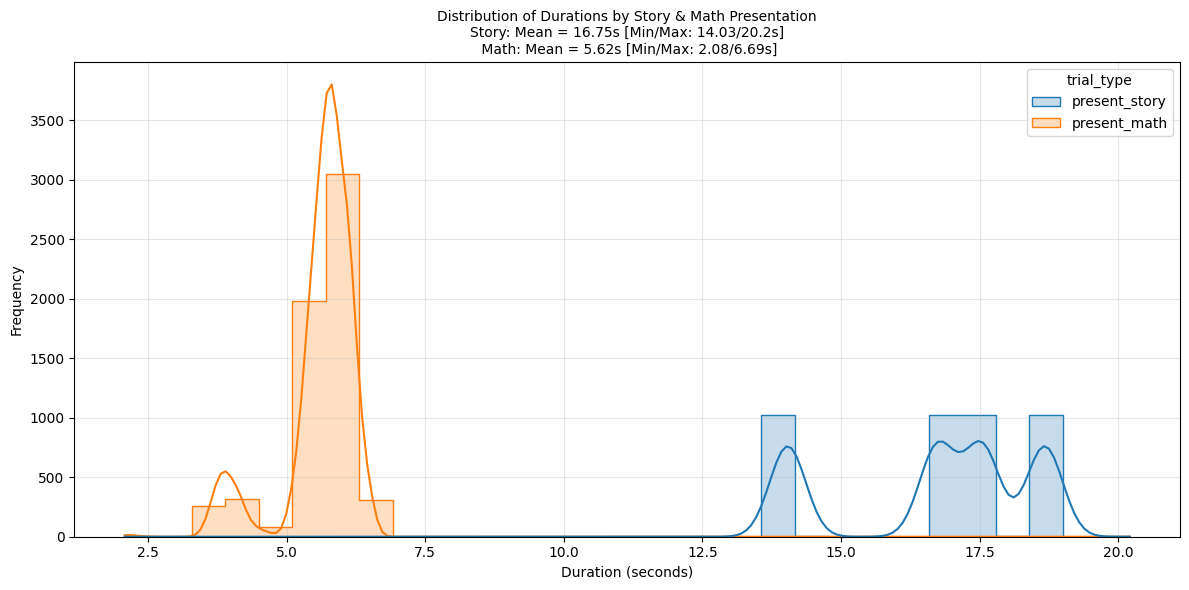

In [12]:
presentation = language_df[language_df['trial_type'].str.contains('present_story|present_math', case=False, na=False)]

# Compute summary statistics for each trial_type
stats = presentation.groupby('trial_type')['duration'].agg(['mean', 'min', 'max']).round(2)

# Extract values
story_mean, story_min, story_max = stats.loc['present_story']
math_mean, math_min, math_max = stats.loc['present_math']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=presentation, 
    x='duration', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations by Story & Math Presentation\n"
    f"Story: Mean = {story_mean}s [Min/Max: {story_min}/{story_max}s]\n "
    f"Math: Mean = {math_mean}s [Min/Max: {math_min}/{math_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-presentationduration", dpi=300, bbox_inches='tight')

plt.tight_layout()

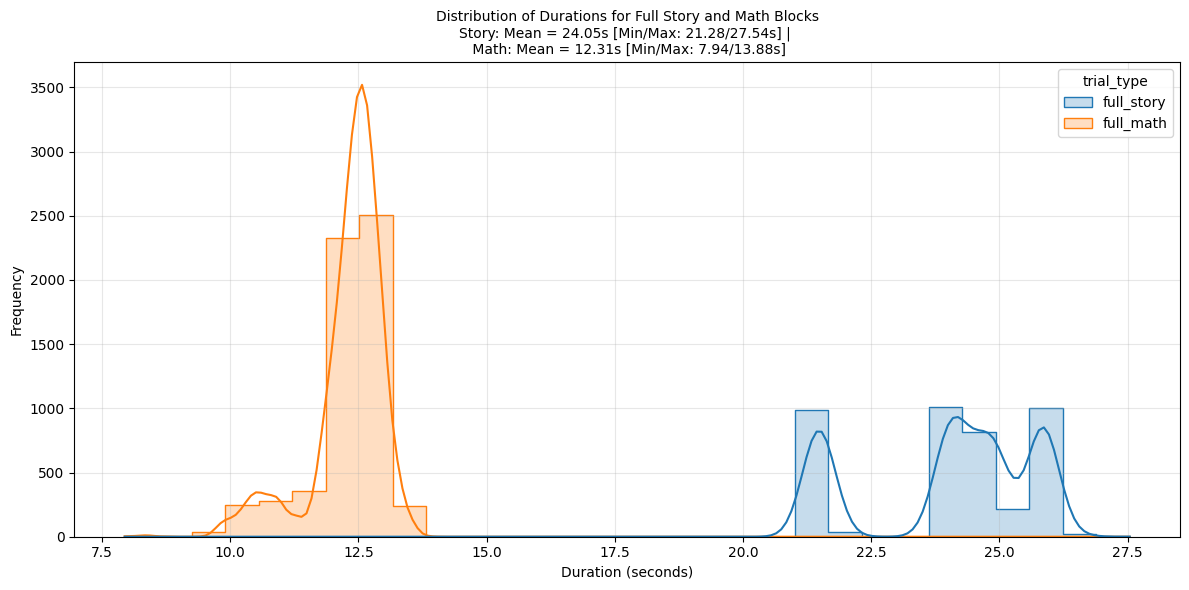

In [13]:
full_block = language_df[language_df['trial_type'].str.contains('full_story|full_math', case=False, na=False)]
stats = full_block.groupby('trial_type')['duration'].agg(['mean', 'min', 'max']).round(2)

story_mean, story_min, story_max = stats.loc['full_story']
math_mean, math_min, math_max = stats.loc['full_math']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=full_block, 
    x='duration', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations for Full Story and Math Blocks\n"
    f"Story: Mean = {story_mean}s [Min/Max: {story_min}/{story_max}s] | \n "
    f"Math: Mean = {math_mean}s [Min/Max: {math_min}/{math_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fullblockdurations", dpi=300, bbox_inches='tight')

plt.show()


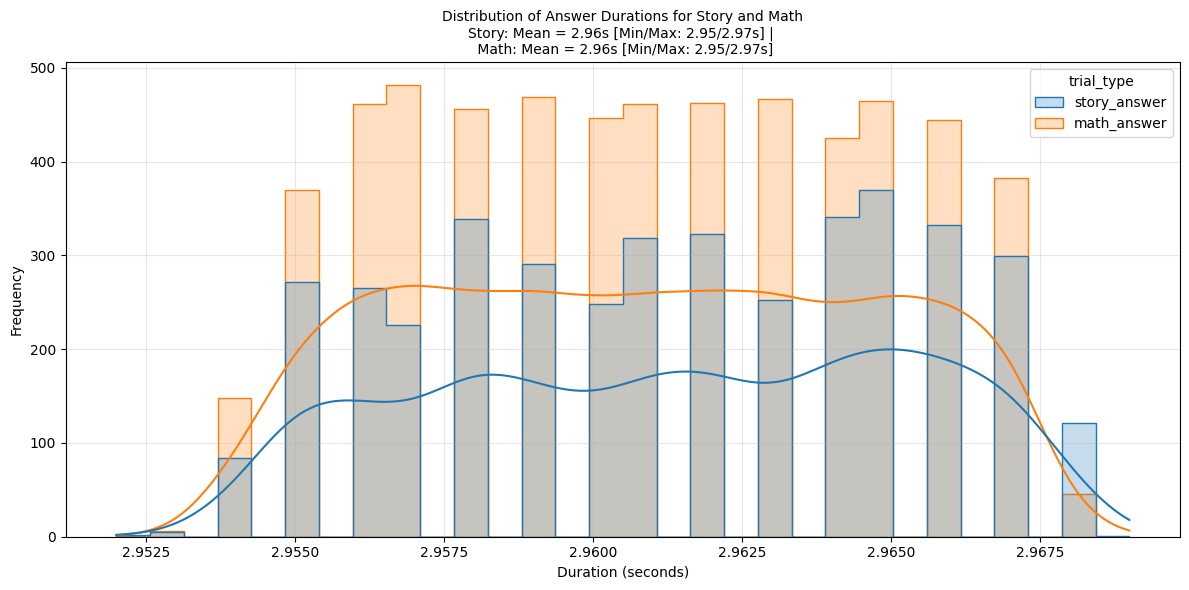

In [14]:
answers = language_df[language_df['trial_type'].str.contains('story_answer|math_answer', case=False, na=False)]
stats = answers.groupby('trial_type')['duration'].agg(['mean', 'min', 'max']).round(2)

story_mean, story_min, story_max = stats.loc['story_answer']
math_mean, math_min, math_max = stats.loc['math_answer']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=answers, 
    x='duration', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Answer Durations for Story and Math\n"
    f"Story: Mean = {story_mean}s [Min/Max: {story_min}/{story_max}s] | \n "
    f"Math: Mean = {math_mean}s [Min/Max: {math_min}/{math_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-answerdurations", dpi=300, bbox_inches='tight')

plt.show()


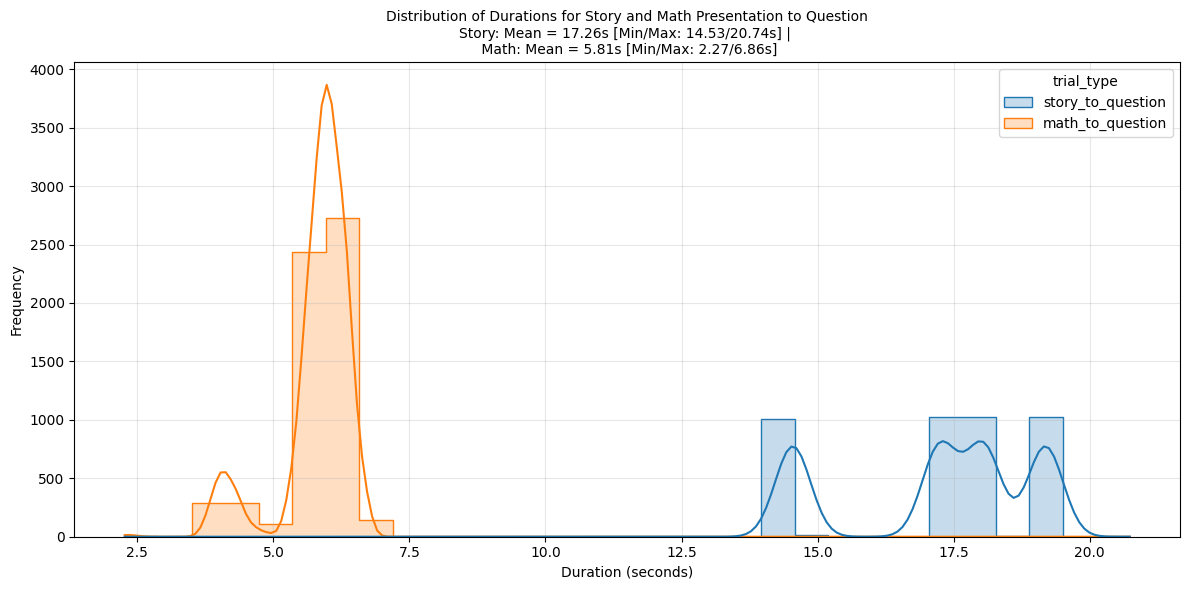

In [15]:
to_question = language_df[language_df['trial_type'].str.contains('story_to_question|math_to_question', case=False, na=False)]
stats = to_question.groupby('trial_type')['duration'].agg(['mean', 'min', 'max']).round(2)

story_mean, story_min, story_max = stats.loc['story_to_question']
math_mean, math_min, math_max = stats.loc['math_to_question']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=to_question, 
    x='duration', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations for Story and Math Presentation to Question\n"
    f"Story: Mean = {story_mean}s [Min/Max: {story_min}/{story_max}s] | \n "
    f"Math: Mean = {math_mean}s [Min/Max: {math_min}/{math_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-cuetoquestionduration", dpi=300, bbox_inches='tight')

plt.show()


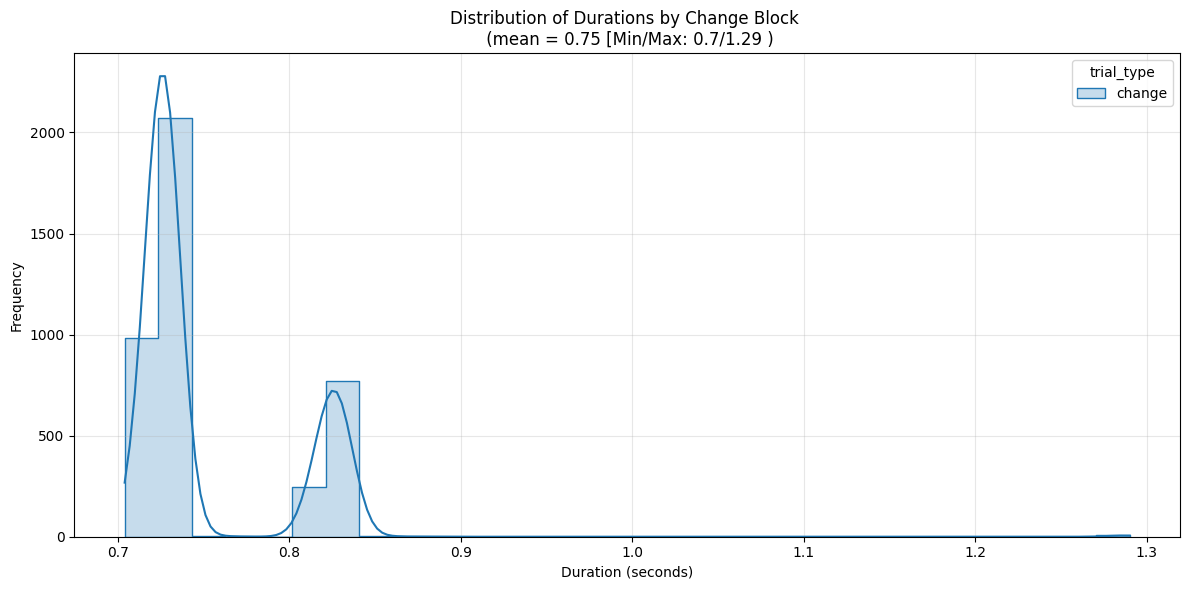

In [16]:
change = language_df[language_df['trial_type'].str.contains('change', case=False)]

duration_mean = np.round(change['duration'].mean(),2)
duration_min = np.round(change['duration'].min(),2)
duration_max = np.round(change['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=change, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations by Change Block \n (mean = {duration_mean} [Min/Max: {duration_min}/{duration_max} )")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-changeblockdurations", dpi=300, bbox_inches='tight')

plt.show()

### Response times

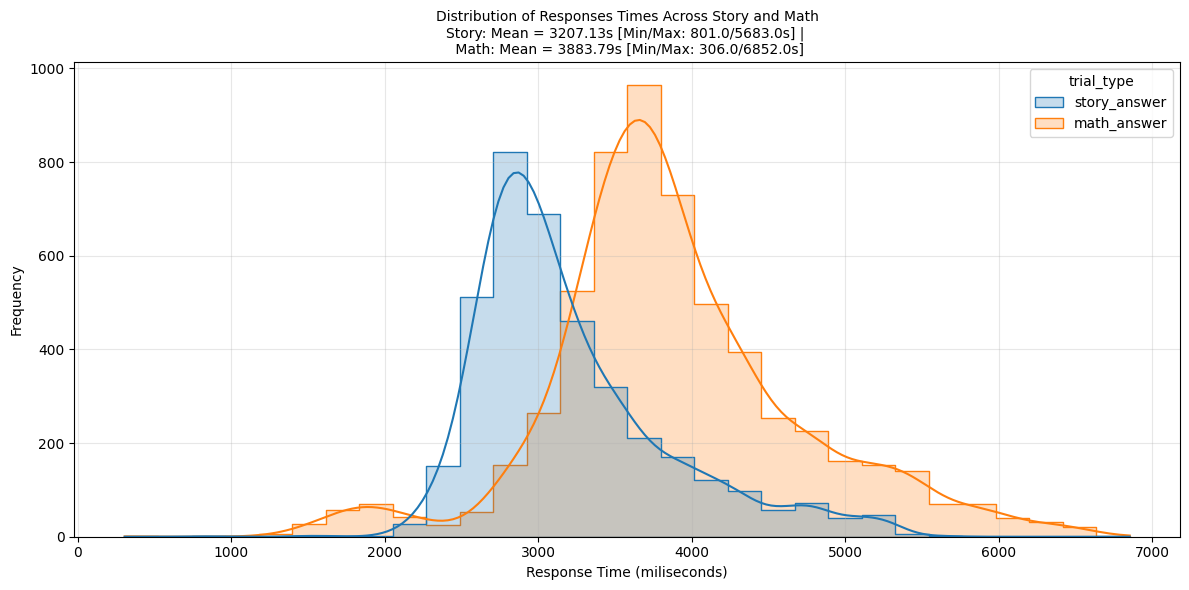

In [17]:
response_times = language_df[language_df['trial_type'].str.contains('story_answer|math_answer', case=False, na=False)]
stats = answers.groupby('trial_type')['response_time'].agg(['mean', 'min', 'max']).round(2)

story_mean, story_min, story_max = stats.loc['story_answer']
math_mean, math_min, math_max = stats.loc['math_answer']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=answers, 
    x='response_time', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Responses Times Across Story and Math\n"
    f"Story: Mean = {story_mean}s [Min/Max: {story_min}/{story_max}s] | \n "
    f"Math: Mean = {math_mean}s [Min/Max: {math_min}/{math_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Response Time (miliseconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-responsetimesdist", dpi=300, bbox_inches='tight')

plt.show()

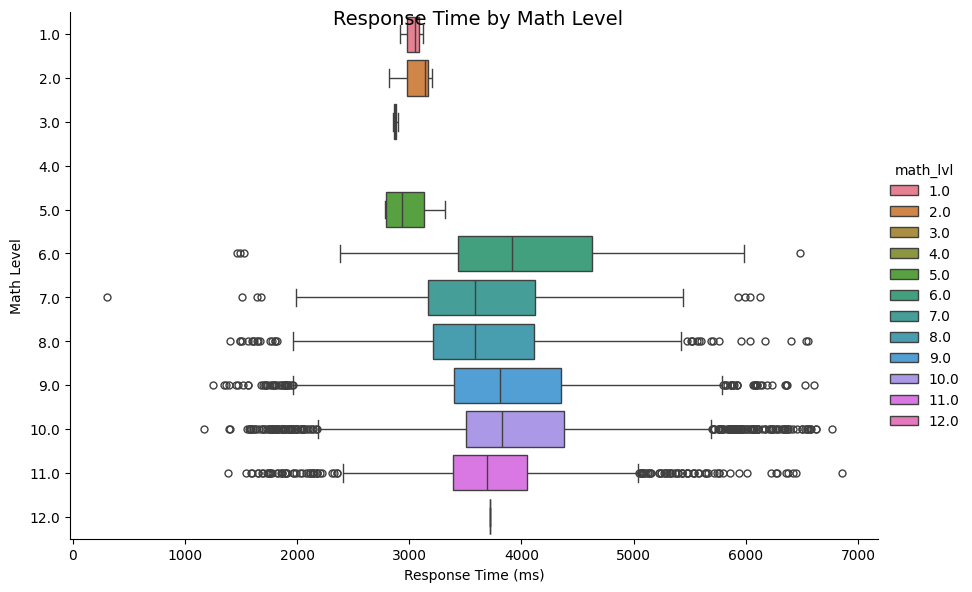

In [18]:
response_times = language_df[language_df['trial_type'].str.contains('math_answer', case=False, na=False)]
response_times = response_times.copy()  # Ensures it's a standalone DataFrame
response_times.loc[:, 'math_lvl'] = response_times['math_lvl'].astype('category')

# Create the box plot
g = sns.catplot(
    data=response_times, 
    x="response_time", 
    y="math_lvl", 
    hue="math_lvl", 
    kind="box", 
    height=6, 
    aspect=1.5
)

# Label the axes
g.set_axis_labels("Response Time (ms)", "Math Level")

# Title for the plot
g.fig.suptitle("Response Time by Math Level", fontsize=14)

# Show the plot
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-responsetimesmathdiff.png", dpi=300, bbox_inches='tight')

plt.show()

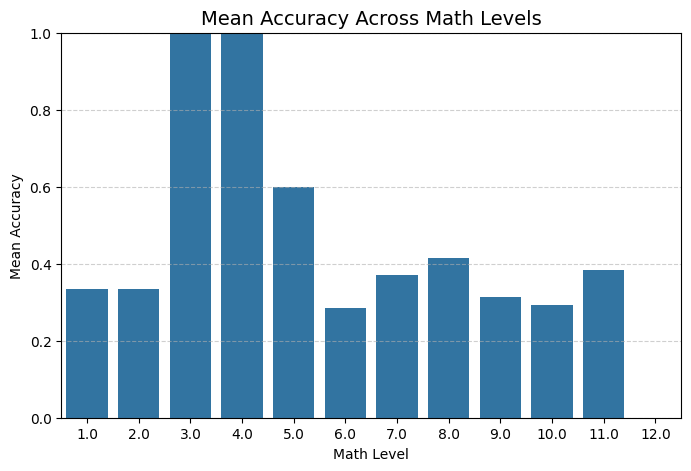

In [19]:
response_times.copy()
response_times.loc[:, 'math_lvl'] = response_times['math_lvl'].astype('category')

# Compute mean accuracy for each math level
accuracy_means = response_times.groupby('math_lvl')['accuracy'].mean().reset_index()

# Create a bar plot for mean accuracy
plt.figure(figsize=(8, 5))
sns.barplot(data=accuracy_means, x='math_lvl', y='accuracy')

# Label the axes
plt.xlabel("Math Level")
plt.ylabel("Mean Accuracy")
plt.title("Mean Accuracy Across Math Levels", fontsize=14)

# Show the plot
plt.ylim(0, 1)  # Since accuracy is between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-mathdiffaccuracy.png", dpi=300, bbox_inches='tight')

plt.show()

## MOTOR

The [Barch et al. (2013, pg 177-178)](https://www.sciencedirect.com/science/article/pii/S1053811913005272) highlights the Language Task as:


"Motor. This task was adapted from the one developed by Buckner and colleagues which had evidence that it could identify effector specific activations in individual subjects (Buckner et al., 2011; Yeo et al., 2011). The participants are presented with visual cues that ask them to tap their left or right fingers, squeeze their left or right toes, or move their tongue to map motor areas. Each block of a movement type lasts 12 s (10 movements), and is preceded by a 3 s cue. In each of the two runs, there are 13 blocks, with 2 of tongue movements, 4 of hand movements (2 right and 2 left), 4 of foot movements (2 right and 2 left) and three 15 s fixation blocks per run."

In [61]:
task = 'motor'
run = 'run-1'

files = sorted(Path(events_folder).rglob(f"sub-*_ses-3T_task-{task}_dir-*_{run}_events.tsv"))
combined = []
for sub_file in files:
    subject = sub_file.parts[-4]    
    out = pd.read_csv(sub_file, sep='\t')
    combined.append((subject, out))  # Append tuple of subject ID and processed dataframe
motor_df = pd.concat([df.assign(subject=subject) for subject, df in combined], ignore_index=True)
print("Rows in final Df:", len(motor_df), "for unique subjects:", len(motor_df['subject'].unique()))

Rows in final Df: 24978 for unique subjects: 1086


### Distribution of First/Last Onset Time

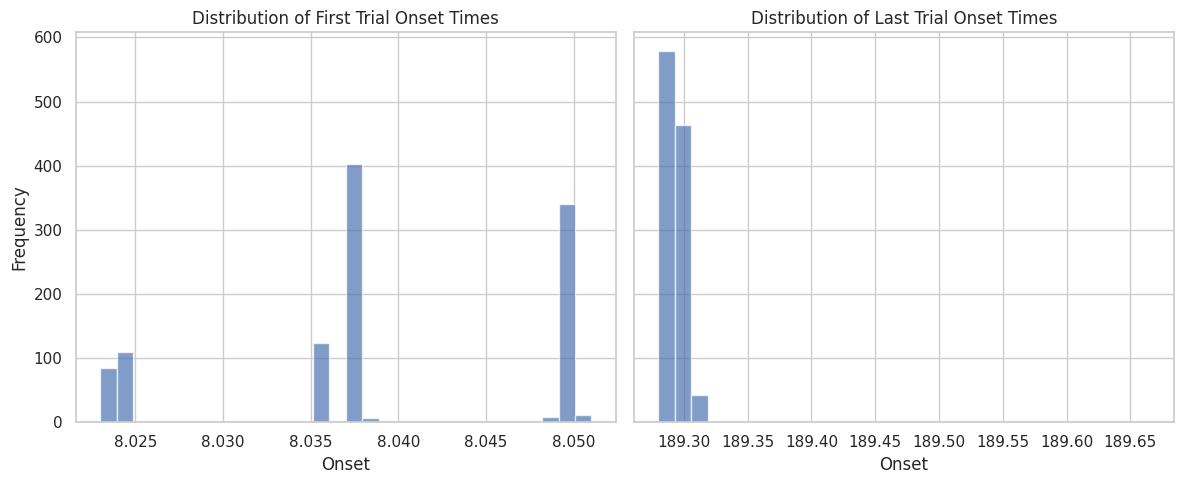

In [62]:
onset_times = motor_df.groupby("subject")["onset"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Onset Times")
axes[0].set_xlabel("Onset")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Onset Times")
axes[1].set_xlabel("Onset")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstonsets.png", dpi=300, bbox_inches='tight')

plt.show()

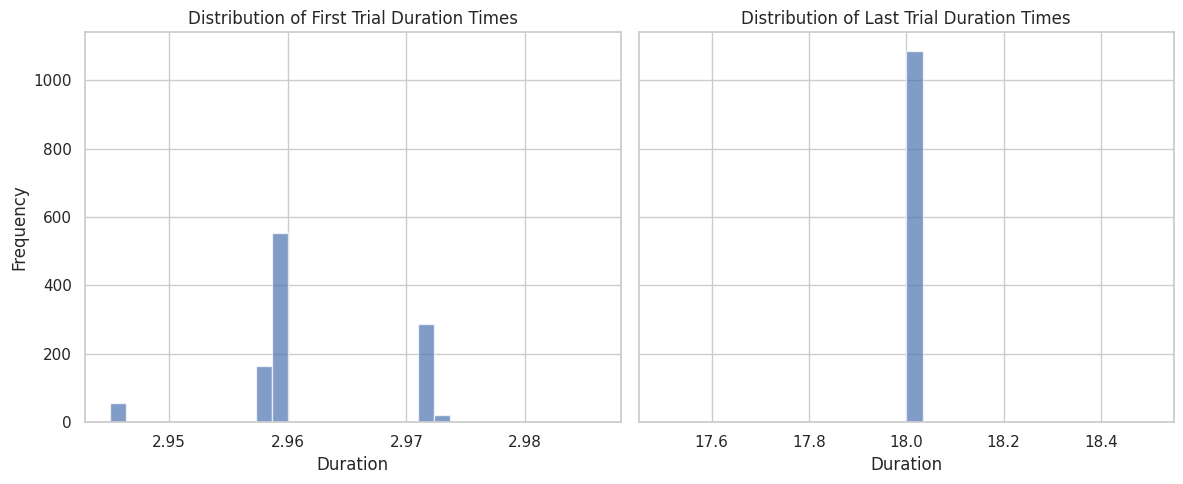

In [63]:
onset_times = motor_df.groupby("subject")["duration"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Duration Times")
axes[0].set_xlabel("Duration")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Duration Times")
axes[1].set_xlabel("Duration")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstdurations.png", dpi=300, bbox_inches='tight')

plt.show()

### Distribution of Durations

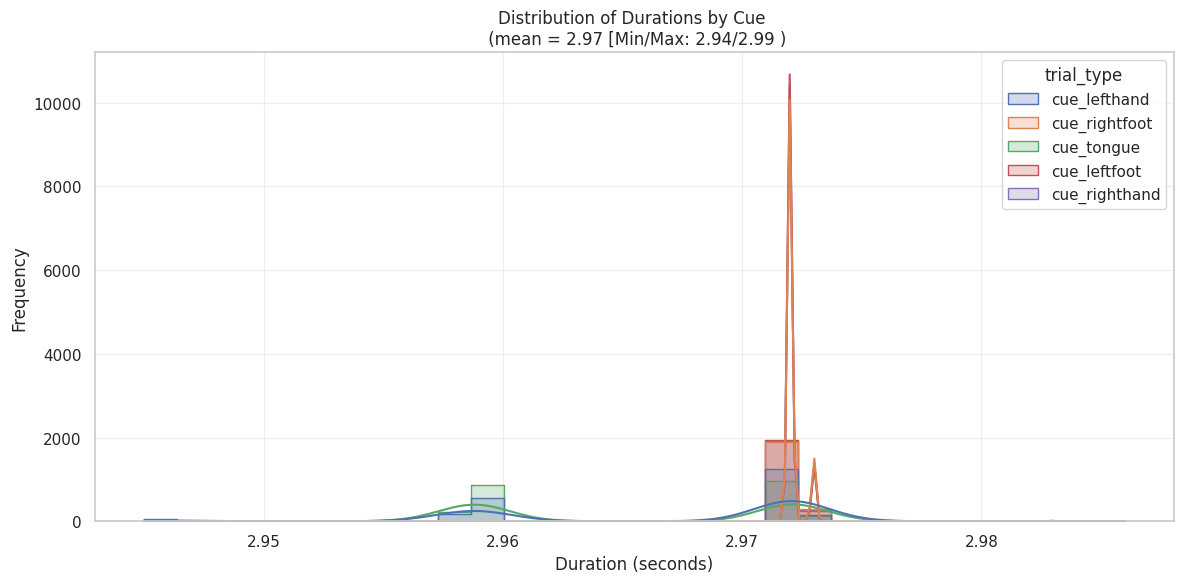

In [64]:
cue_dur = motor_df[motor_df['trial_type'].str.contains('cue', case=False)]

duration_mean = np.round(cue_dur['duration'].mean(),2)
duration_min = np.round(cue_dur['duration'].min(),2)
duration_max = np.round(cue_dur['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=cue_dur, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations by Cue \n (mean = {duration_mean} [Min/Max: {duration_min}/{duration_max} )")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-cuedurations.png", dpi=300, bbox_inches='tight')

plt.show()

Fixation is constant of 18, as trial-by-trial hovers near this and does not vary. Calculating unique across blocks added unnecessary risks of erros.

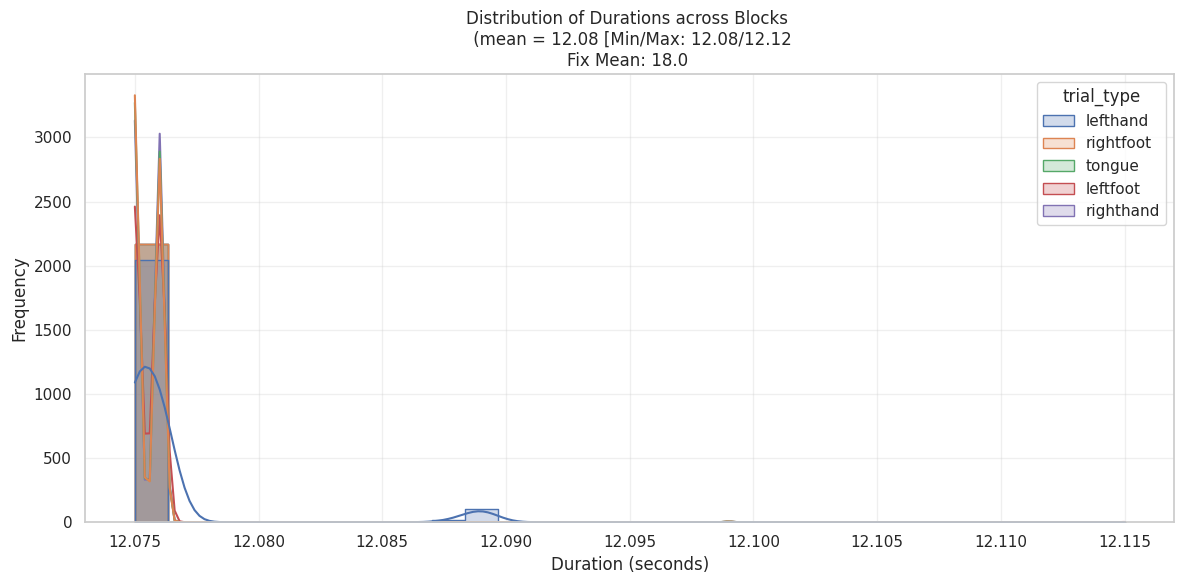

In [65]:
fixdur = motor_df[motor_df['trial_type'].str.contains('fixation', case=False, na=False)]
fixdur_mean = np.round(fixdur['duration'].mean(),2)

blocks = motor_df[
    motor_df['trial_type'].str.contains('lefthand|righthand|rightfoot|leftfoot|tongue', case=False, na=False) & 
    ~motor_df['trial_type'].str.contains('cue', case=False, na=False)
]

duration_mean = np.round(blocks['duration'].mean(),2)
duration_min = np.round(blocks['duration'].min(),2)
duration_max = np.round(blocks['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=blocks, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations across Blocks \n (mean = {duration_mean} [Min/Max: {duration_min}/{duration_max}\nFix Mean: {fixdur_mean} ")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-moveblockdurations.png", dpi=300, bbox_inches='tight')

plt.show()

## Social

The [Barch et al. (2013, pg 178)](https://www.sciencedirect.com/science/article/pii/S1053811913005272) highlights the Social Task as:


"Social cognition (theory of mind). An engaging and validated video task was chosen as a measure of social cognition, given evidence that it generates robust task related activation in brain regions associated with social cognition and is reliable across subjects (Castelli et al., 2000, 2002; Wheatley et al., 2007; White et al., 2011). The participants are presented with short video clips (20 s) of objects (squares, circles, triangles) either interacting in some way, or moving randomly. These videos were developed by either Castelli et al. (2000) or Wheatley et al. (2007). After each video clip, the participants chose between 3 possibilities: whether the objects had a social interaction (an interaction that appears as if the shapes are taking into account each other's feelings and thoughts), Not Sure, or No interaction (i.e., there is no obvious interaction between the shapes and the  movement appears in random). Each of the two task runs has 5 video blocks (2 Mental and 3 Random in one run, 3 Mental and 2 Random in the other run) and 5 fixation blocks (15 s each). Of note, the video clips were shortened to 20 s (the Castelli et al. clips were originally 40 s) by either splitting the videos in two or truncating them. We conducted a pilot study in Phase I in which the participants made ratings about the presence or absence of mental interactions in the videos to confirm that the shorter videos elicited similar responses to the longer videos."

In [69]:
task = 'social'
run = 'run-1'

files = sorted(Path(events_folder).rglob(f"sub-*_ses-3T_task-{task}_dir-*_{run}_events.tsv"))
combined = []
for sub_file in files:
    subject = sub_file.parts[-4]    
    out = pd.read_csv(sub_file, sep='\t')
    combined.append((subject, out))  # Append tuple of subject ID and processed dataframe
social_df = pd.concat([df.assign(subject=subject) for subject, df in combined], ignore_index=True)
print("Rows in final Df:", len(social_df), "for unique subjects:", len(social_df['subject'].unique()))

Rows in final Df: 20940 for unique subjects: 1047


### Distribution First/Last timing

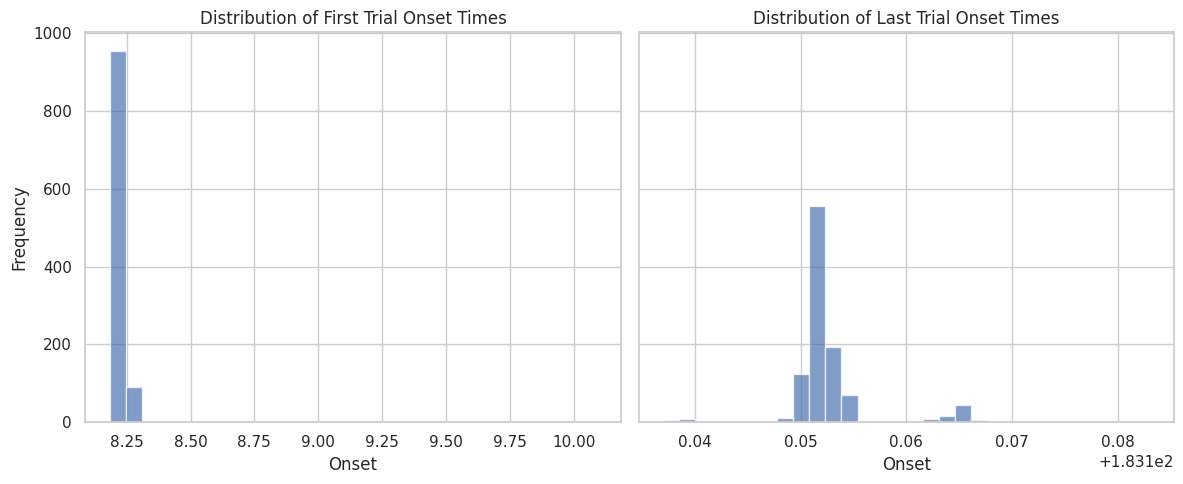

In [72]:
onset_times = social_df.groupby("subject")["onset"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Onset Times")
axes[0].set_xlabel("Onset")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Onset Times")
axes[1].set_xlabel("Onset")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstonsets.png", dpi=300, bbox_inches='tight')
plt.show()

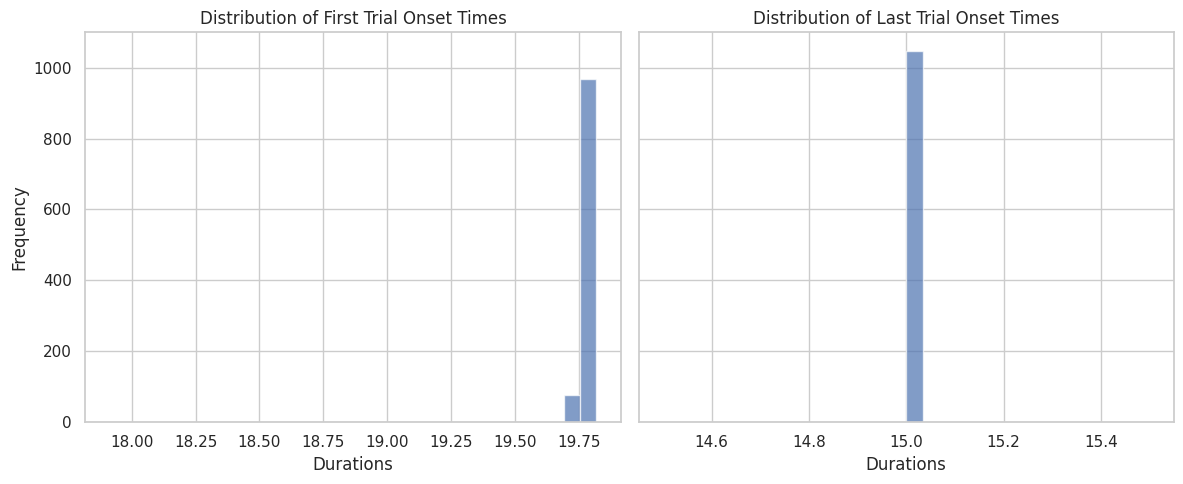

In [75]:
onset_times = social_df.groupby("subject")["duration"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Onset Times")
axes[0].set_xlabel("Durations")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Onset Times")
axes[1].set_xlabel("Durations")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstduration.png", dpi=300, bbox_inches='tight')
plt.show()

### Distribution of Durations

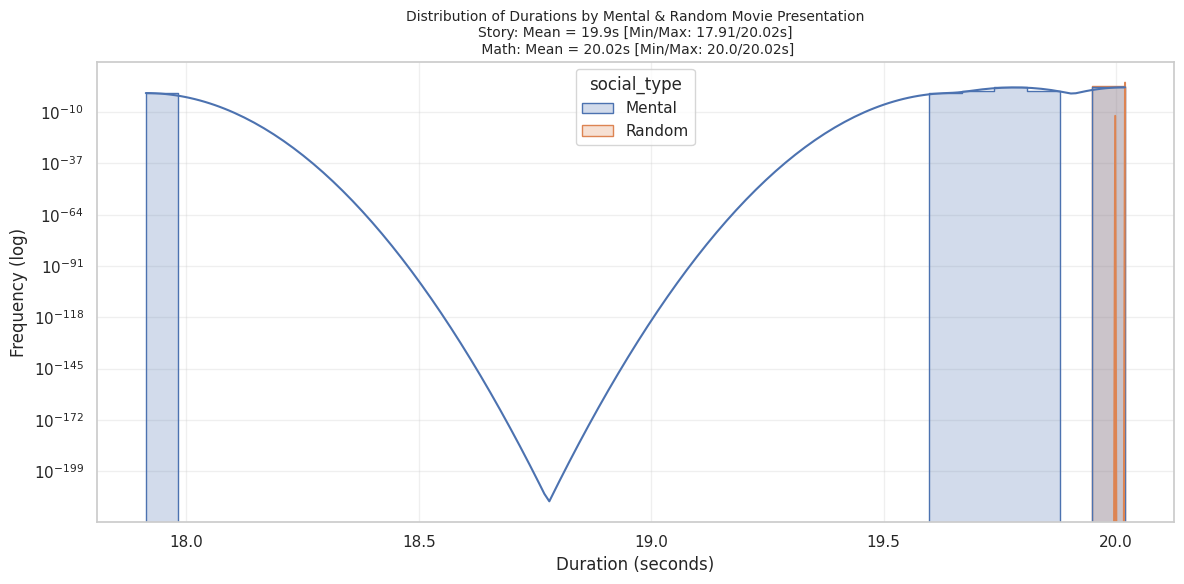

In [76]:
presentation = social_df[social_df['trial_type'].str.contains('movie', case=False, na=False)]

# Compute summary statistics for each trial_type
stats = presentation.groupby('social_type')['duration'].agg(['mean', 'min', 'max']).round(2)

# Extract values
mental_mean, mental_min, mental_max = stats.loc['Mental']
rand_mean, rand_min, rand_max = stats.loc['Random']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=presentation, 
    x='duration', 
    hue='social_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations by Mental & Random Movie Presentation\n"
    f"Story: Mean = {mental_mean}s [Min/Max: {mental_min}/{mental_max}s]\n "
    f"Math: Mean = {rand_mean}s [Min/Max: {rand_min}/{rand_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.yscale("log")  # Log scale to better see differences
plt.ylabel('Frequency (log)')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-presentationduration.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

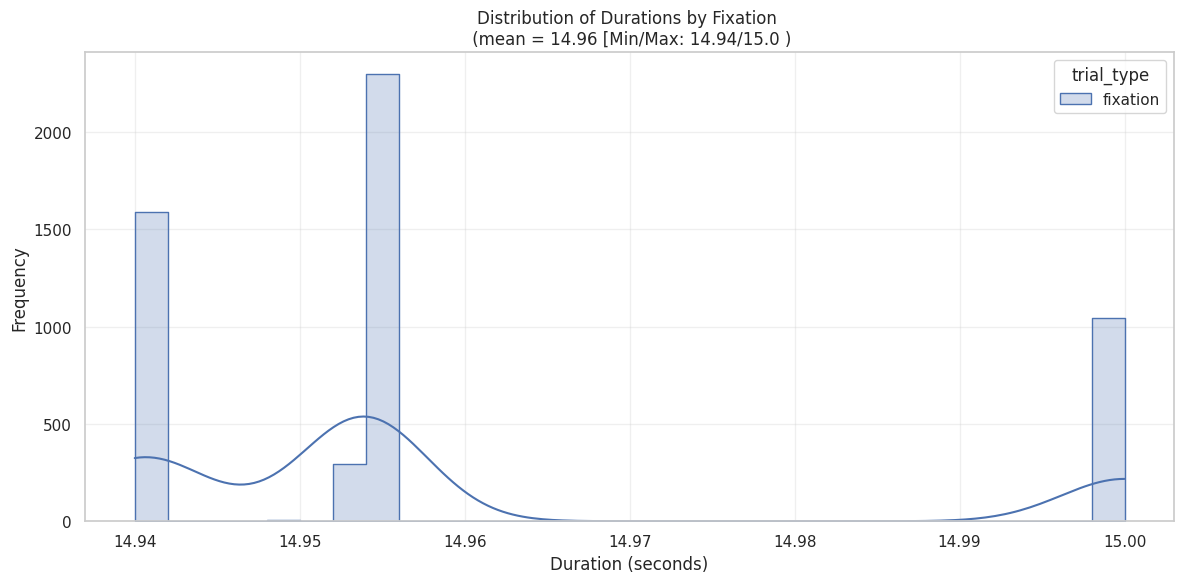

In [77]:
fixation = social_df[social_df['trial_type'].str.contains('fixation', case=False)]

duration_mean = np.round(fixation['duration'].mean(),2)
duration_min = np.round(fixation['duration'].min(),2)
duration_max = np.round(fixation['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=fixation, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations by Fixation \n (mean = {duration_mean} [Min/Max: {duration_min}/{duration_max} )")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fixationduration.png", dpi=300, bbox_inches='tight')

plt.show()

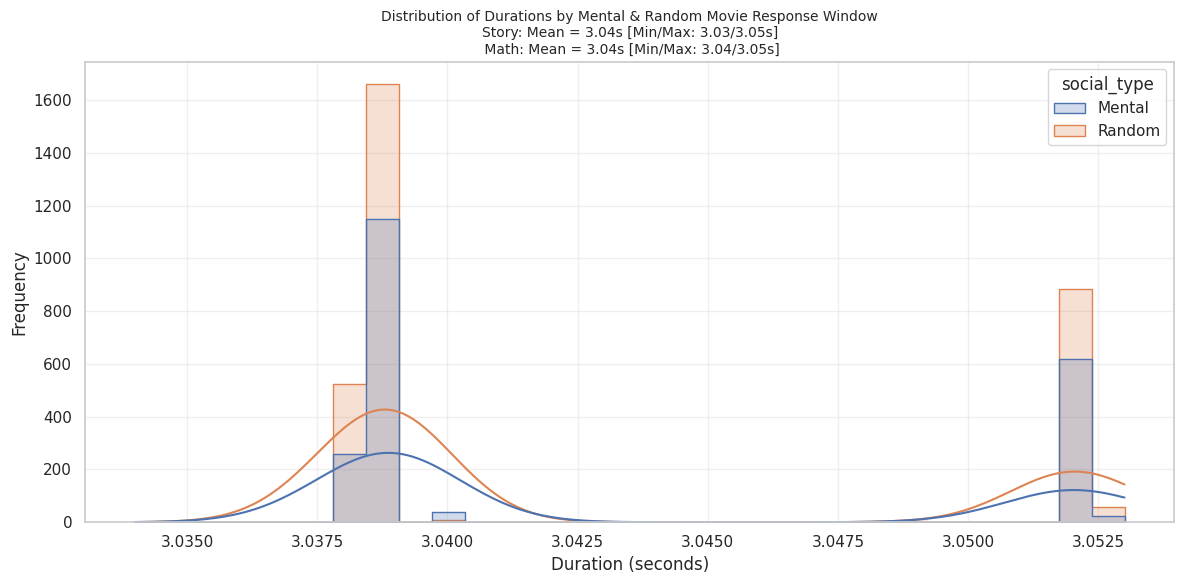

In [78]:
response = social_df[social_df['trial_type'].str.contains('response', case=False, na=False)]

# Compute summary statistics for each trial_type
stats = response.groupby('social_type')['duration'].agg(['mean', 'min', 'max']).round(2)

# Extract values
mental_mean, mental_min, mental_max = stats.loc['Mental']
rand_mean, rand_min, rand_max = stats.loc['Random']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=response, 
    x='duration', 
    hue='social_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations by Mental & Random Movie Response Window\n"
    f"Story: Mean = {mental_mean}s [Min/Max: {mental_min}/{mental_max}s]\n "
    f"Math: Mean = {rand_mean}s [Min/Max: {rand_min}/{rand_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-responseduration.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

### Response Times

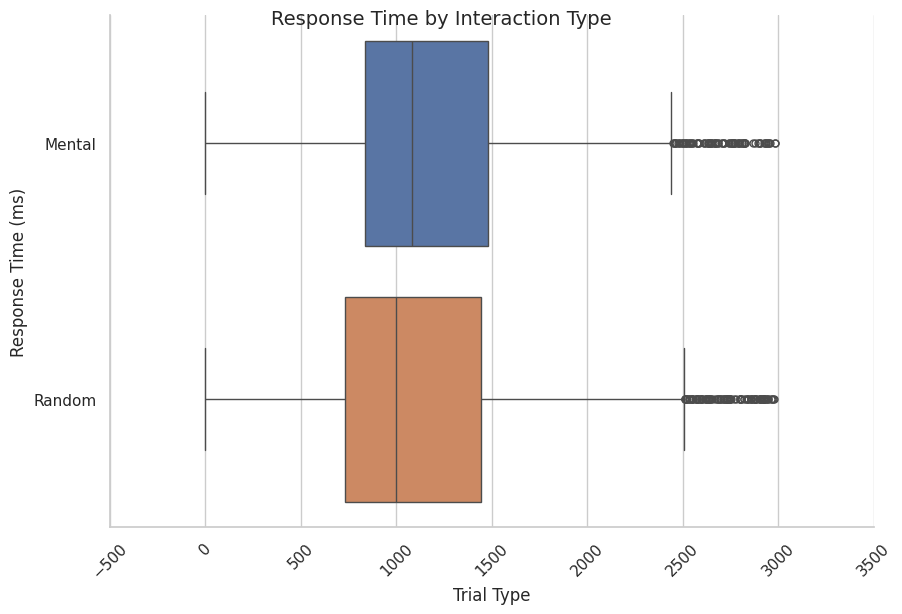

In [79]:
response_times = social_df[social_df['trial_type'].str.contains('response', case=False)]

# Create the plot with facets by stim_type
g = sns.catplot(data=response_times, x="response_time", y="social_type", hue="social_type", kind="box", height=6, aspect=1.5)

# Label the axes
g.set_axis_labels("Trial Type", "Response Time (ms)")

# Title for the entire plot
g.fig.suptitle("Response Time by Interaction Type", fontsize=14)

# Rotate x-axis labels if necessary
g.set_xticklabels(rotation=45)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-responsetimebyinteraction.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

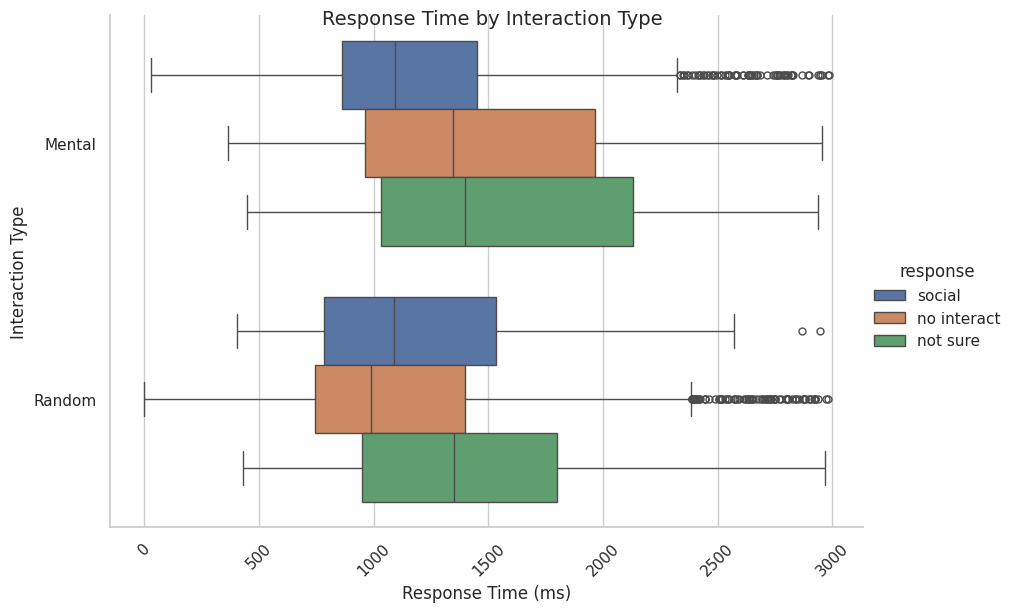

In [80]:
response_times = social_df[social_df['trial_type'].str.contains('response', case=False)].copy()

# **Recode Response Types**
response_mapping = {2: "social", 3: "not sure", 4: "no interact"}
response_times["response"] = response_times["response"].replace(response_mapping)

# Create the box plot
g = sns.catplot(
    data=response_times, 
    x="response_time", 
    y="social_type", 
    hue="response",  # Hue now reflects the relabeled response types
    kind="box", 
    height=6, 
    aspect=1.5
)

# Label axes
g.set_axis_labels("Response Time (ms)", "Interaction Type")

# Title for the plot
g.fig.suptitle("Response Time by Interaction Type", fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Save the figure before plt.show()
g.savefig(f"{out_figs}/task-{task}_run-{run}_type-responsetimebyinteractresptype.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

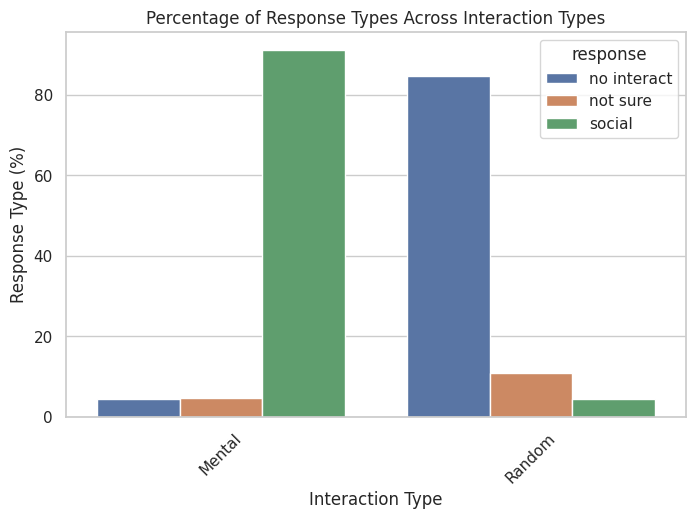

In [81]:
response_counts = response_times.groupby(["social_type", "response"]).size().reset_index(name="count")

# Normalize counts to percentages
response_counts["percent"] = response_counts.groupby("social_type")["count"].transform(lambda x: x / x.sum() * 100)

plt.figure(figsize=(8, 5))
sns.barplot(data=response_counts, x="social_type", y="percent", hue="response")
plt.xlabel("Interaction Type")
plt.ylabel("Response Type (%)")
plt.title("Percentage of Response Types Across Interaction Types")
plt.xticks(rotation=45)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-responsetypeprop.png", dpi=300, bbox_inches='tight')

plt.show()

## Relational

The [Barch et al. (2013, pg 178)](https://www.sciencedirect.com/science/article/pii/S1053811913005272) highlights the Social Task as:


"Relational processing. This task was adapted from the one developed by Smith et al. (2007) which was demonstrated to localize activation in anterior prefrontal cortex in individual subjects. The stimuli are 6 different shapes filled with 1 of 6 different textures. In the relational processing condition, the participants are presented with 2 pairs of objects, with one pair at the top of the screen and the other pair at the bottom of the screen. They are told that they should first decide what dimension differs across the top pair of objects (shape or texture) and then they should decide whether the bottom pair of objects also differs along that same dimension (e.g., if the top pair differs in shape, does the bottom pair also differ in shape). In the control matching condition, the participants are shown two objects at the top of the screen and one object at the bottom of the screen, and a word in the middle of the screen (either “shape” or “texture”). They are told to decide whether the bottom object matches either of the top two objects on that dimension (e.g., if the word is “shape”, is the bottom object the same shape as either of the top two objects). For the relational condition, the stimuli are presented for 3500 ms, with a 500 ms ITI, with four trials per block. In the matching condition, stimuli are presented for 2800 ms, with a 400 ms ITI, with 5 trials per block. Each type of block (relational or matching) lasts a total of 18 s. In each of the two runs of this task, there are 3 relational blocks, 3 matching blocks and three 16 s fixation blocks (see Table 4)."

In [95]:
task = 'relational'
run = 'run1'

files = sorted(Path(events_folder).rglob(f"sub-*_ses-3T_task-{task}_dir-*_{run}_events.tsv"))
combined = []
for sub_file in files:
    subject = sub_file.parts[-4]    
    out = pd.read_csv(sub_file, sep='\t')
    combined.append((subject, out))  # Append tuple of subject ID and processed dataframe
rel_df = pd.concat([df.assign(subject=subject) for subject, df in combined], ignore_index=True)
print("Rows in final Df:", len(rel_df), "for unique subjects:", len(rel_df['subject'].unique()))

Rows in final Df: 62583 for unique subjects: 907


### Distribution of First/Last Onset Time

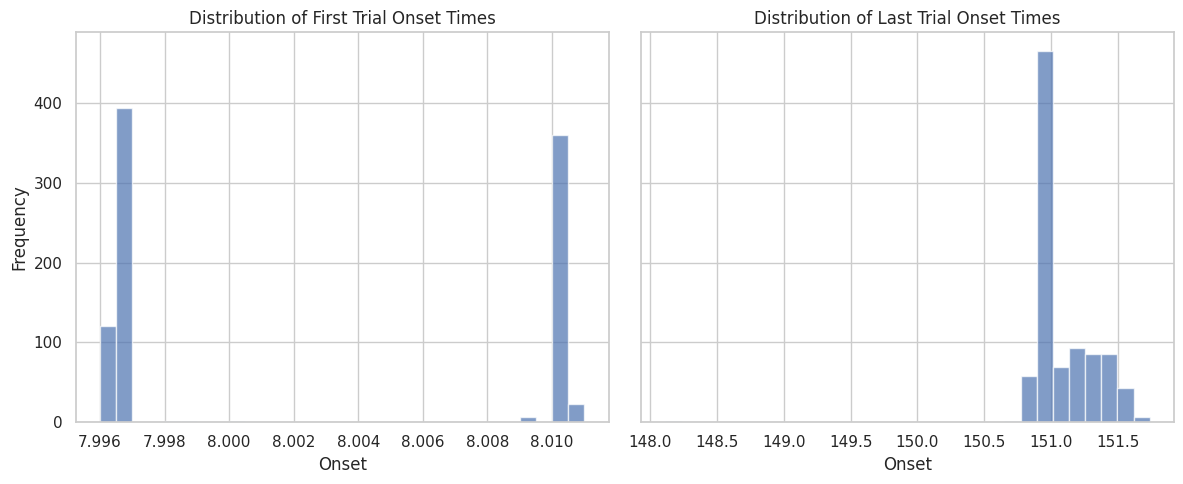

In [96]:
onset_times = rel_df.groupby("subject")["onset"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Onset Times")
axes[0].set_xlabel("Onset")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Onset Times")
axes[1].set_xlabel("Onset")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstonset.png", dpi=300, bbox_inches='tight')

plt.show()

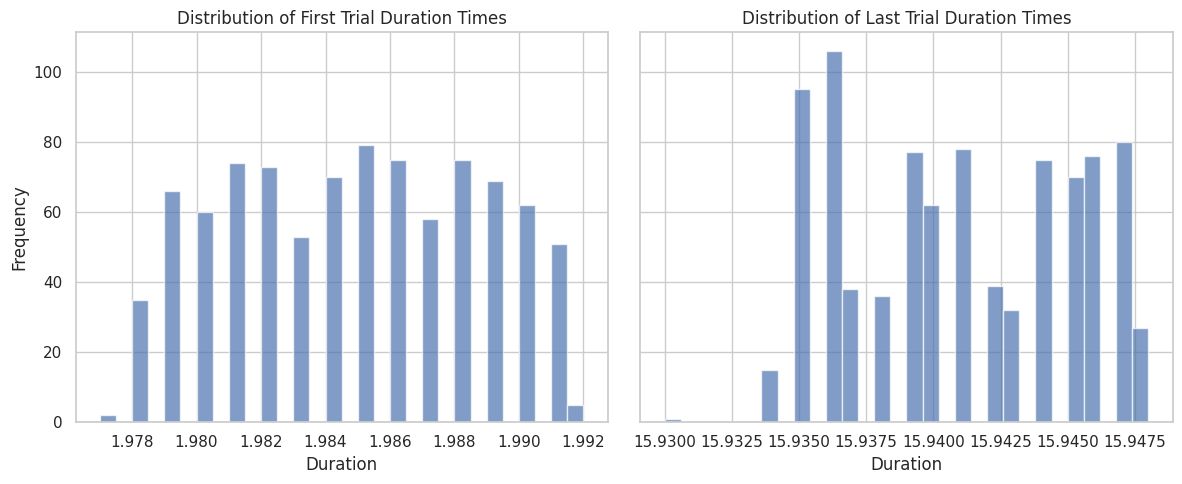

In [97]:
onset_times = rel_df.groupby("subject")["duration"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Duration Times")
axes[0].set_xlabel("Duration")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Duration Times")
axes[1].set_xlabel("Duration")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstduration.png", dpi=300, bbox_inches='tight')

plt.show()

### Distribution of Durations

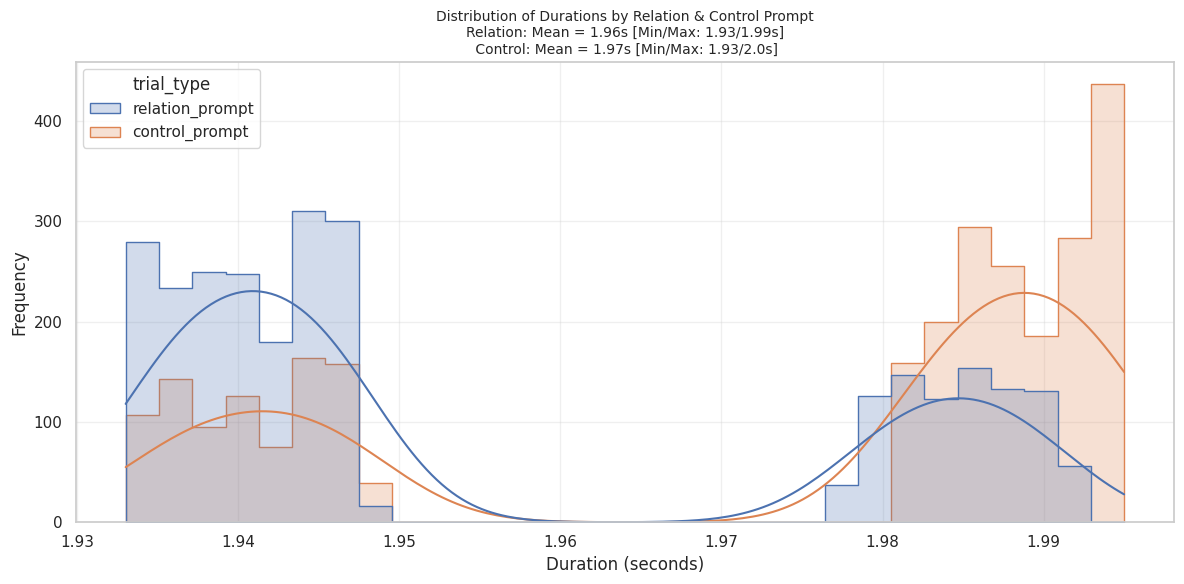

In [98]:
prompt_pres = rel_df[rel_df['trial_type'].str.contains('relation_prompt|control_prompt', case=False, na=False)]

# Compute summary statistics for each trial_type
stats = prompt_pres.groupby('trial_type')['duration'].agg(['mean', 'min', 'max']).round(2)

# Extract values
a_mean, a_min, a_max = stats.loc['relation_prompt']
b_mean, b_min, b_max = stats.loc['control_prompt']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=prompt_pres, 
    x='duration', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations by Relation & Control Prompt\n"
    f"Relation: Mean = {a_mean}s [Min/Max: {a_min}/{a_max}s]\n "
    f"Control: Mean = {b_mean}s [Min/Max: {b_min}/{b_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-promptduration.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

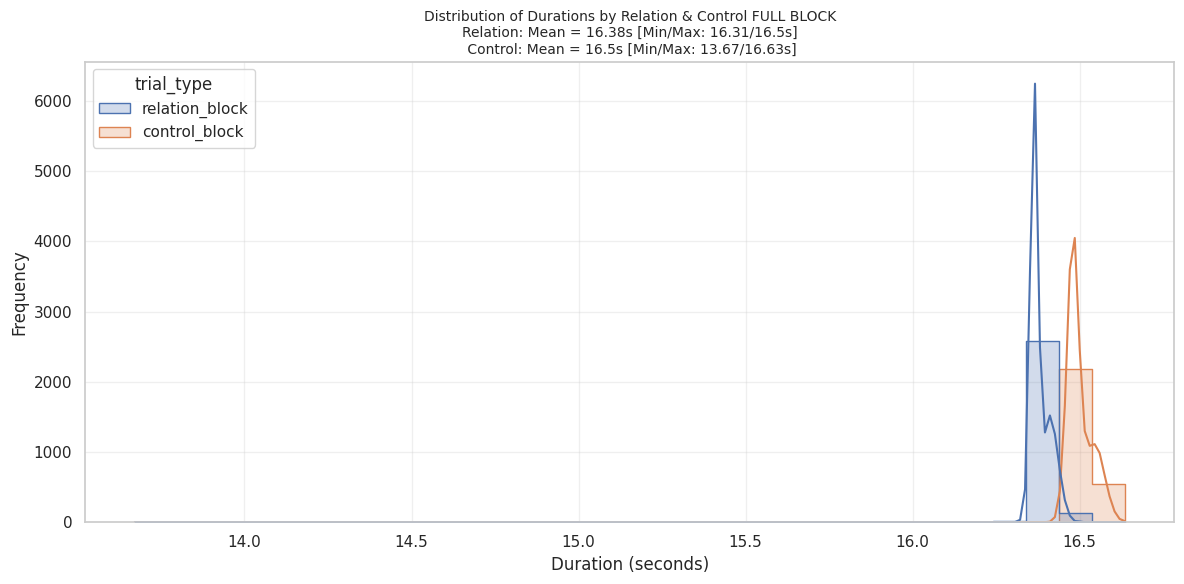

In [99]:
prompt_block = rel_df[rel_df['trial_type'].str.contains('relation_block|control_block', case=False, na=False)]

# Compute summary statistics for each trial_type
stats = prompt_block.groupby('trial_type')['duration'].agg(['mean', 'min', 'max']).round(2)

# Extract values
a_mean, a_min, a_max = stats.loc['relation_block']
b_mean, b_min, b_max = stats.loc['control_block']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=prompt_block, 
    x='duration', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations by Relation & Control FULL BLOCK\n"
    f"Relation: Mean = {a_mean}s [Min/Max: {a_min}/{a_max}s]\n "
    f"Control: Mean = {b_mean}s [Min/Max: {b_min}/{b_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fullblockduration.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

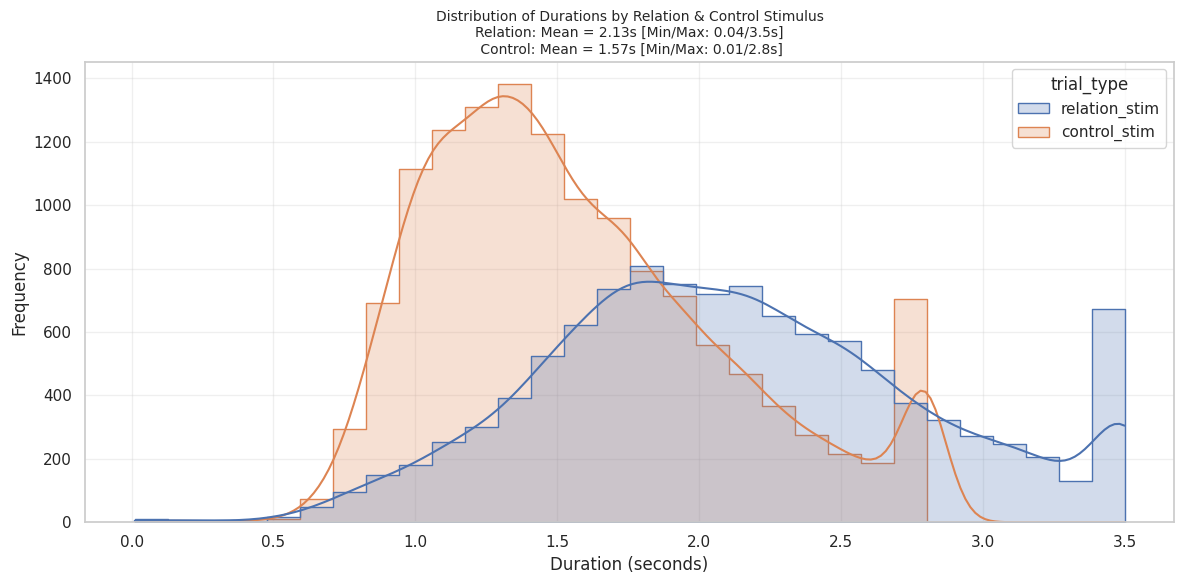

In [100]:
prompt_stim = rel_df[rel_df['trial_type'].str.contains('relation_stim|control_stim', case=False, na=False)]

# Compute summary statistics for each trial_type
stats = prompt_stim.groupby('trial_type')['duration'].agg(['mean', 'min', 'max']).round(2)

# Extract values
a_mean, a_min, a_max = stats.loc['relation_stim']
b_mean, b_min, b_max = stats.loc['control_stim']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=prompt_stim, 
    x='duration', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations by Relation & Control Stimulus\n"
    f"Relation: Mean = {a_mean}s [Min/Max: {a_min}/{a_max}s]\n "
    f"Control: Mean = {b_mean}s [Min/Max: {b_min}/{b_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-stimulusduration.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

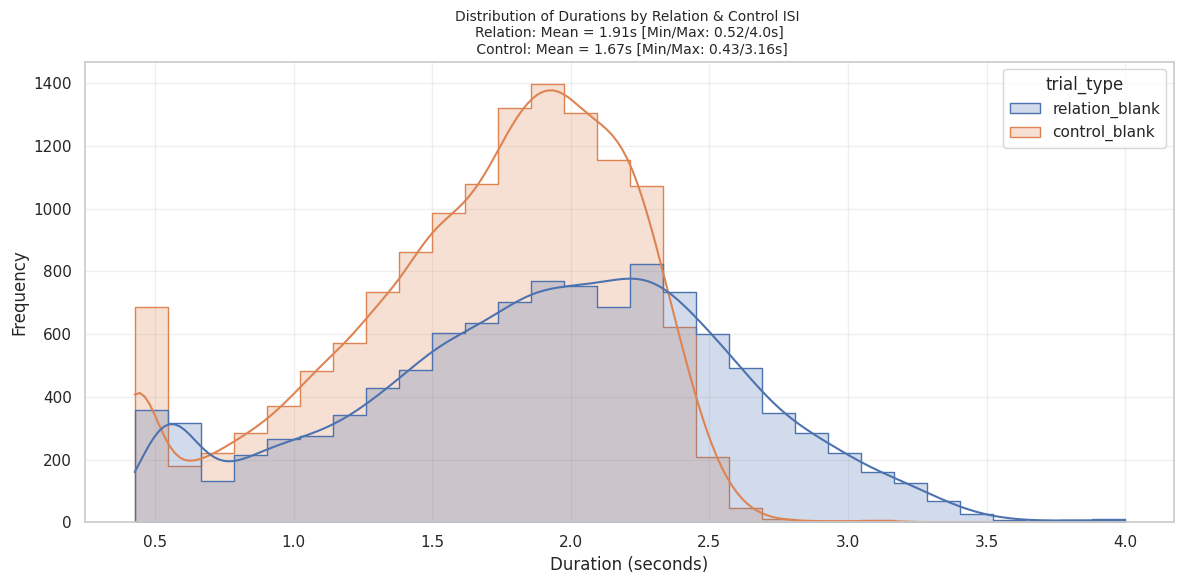

In [101]:
prompt_isi = rel_df[rel_df['trial_type'].str.contains('relation_blank|control_blank', case=False, na=False)]

# Compute summary statistics for each trial_type
stats = prompt_isi.groupby('trial_type')['duration'].agg(['mean', 'min', 'max']).round(2)

# Extract values
a_mean, a_min, a_max = stats.loc['relation_blank']
b_mean, b_min, b_max = stats.loc['control_blank']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=prompt_isi, 
    x='duration', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations by Relation & Control ISI \n"
    f"Relation: Mean = {a_mean}s [Min/Max: {a_min}/{a_max}s]\n "
    f"Control: Mean = {b_mean}s [Min/Max: {b_min}/{b_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-isiduration.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

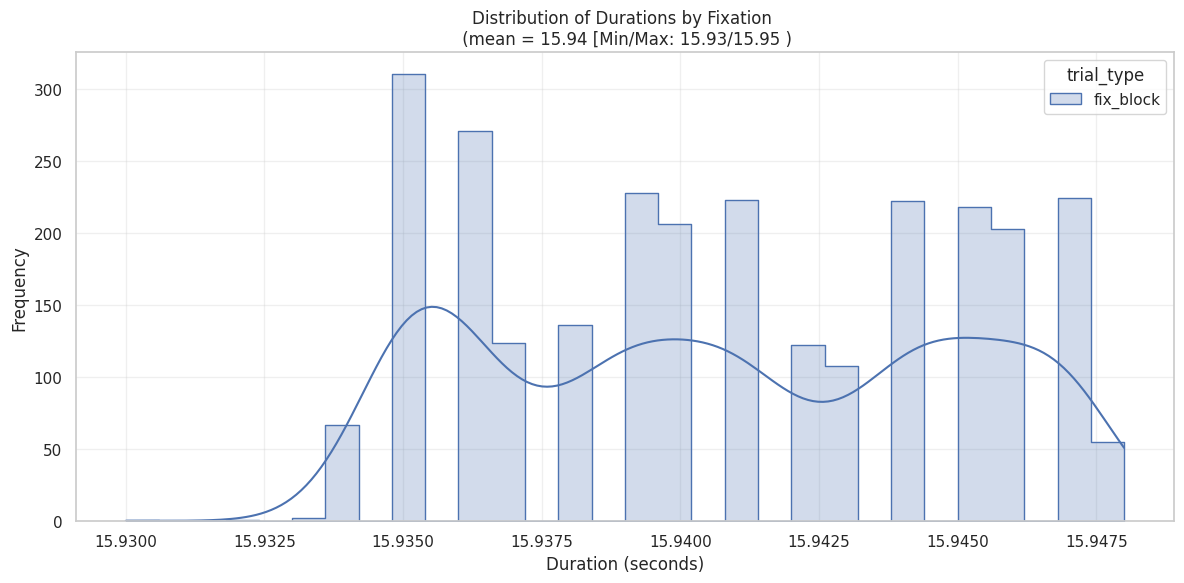

In [102]:
fixation = rel_df[rel_df['trial_type'].str.contains('fix', case=False)]

duration_mean = np.round(fixation['duration'].mean(),2)
duration_min = np.round(fixation['duration'].min(),2)
duration_max = np.round(fixation['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=fixation, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations by Fixation \n (mean = {duration_mean} [Min/Max: {duration_min}/{duration_max} )")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fixationduration.png", dpi=300, bbox_inches='tight')

plt.show()

### Response Times

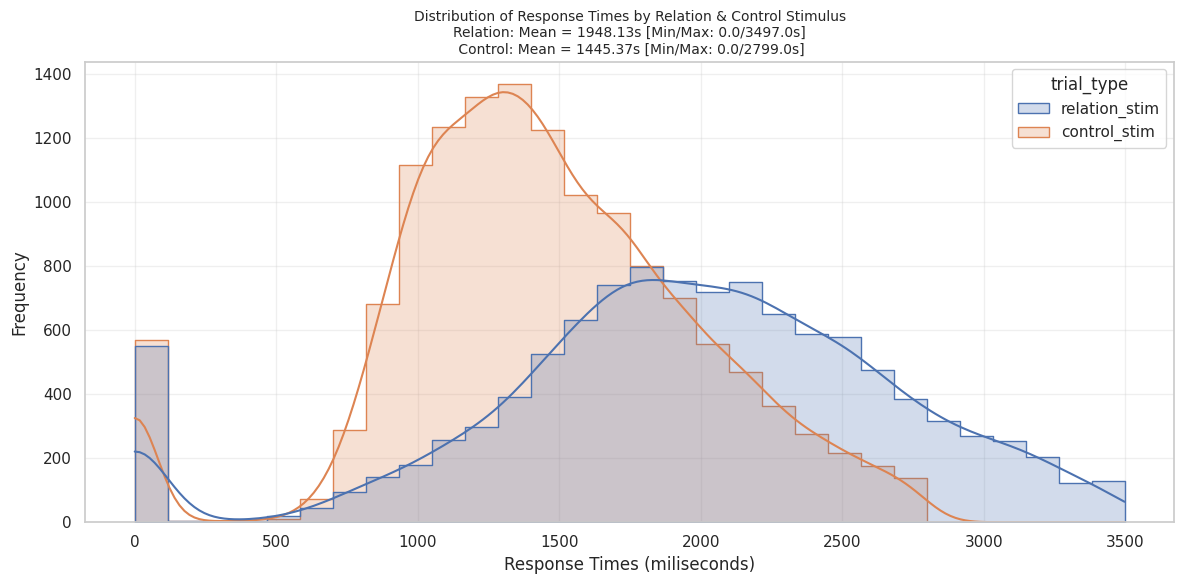

In [103]:
stim_response = rel_df[rel_df['trial_type'].str.contains('relation_stim|control_stim', case=False, na=False)]

# Compute summary statistics for each trial_type
stats = stim_response.groupby('trial_type')['response_time'].agg(['mean', 'min', 'max']).round(2)

# Extract values
a_mean, a_min, a_max = stats.loc['relation_stim']
b_mean, b_min, b_max = stats.loc['control_stim']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=stim_response, 
    x='response_time', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Response Times by Relation & Control Stimulus\n"
    f"Relation: Mean = {a_mean}s [Min/Max: {a_min}/{a_max}s]\n "
    f"Control: Mean = {b_mean}s [Min/Max: {b_min}/{b_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Response Times (miliseconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-responsetimestimulus.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

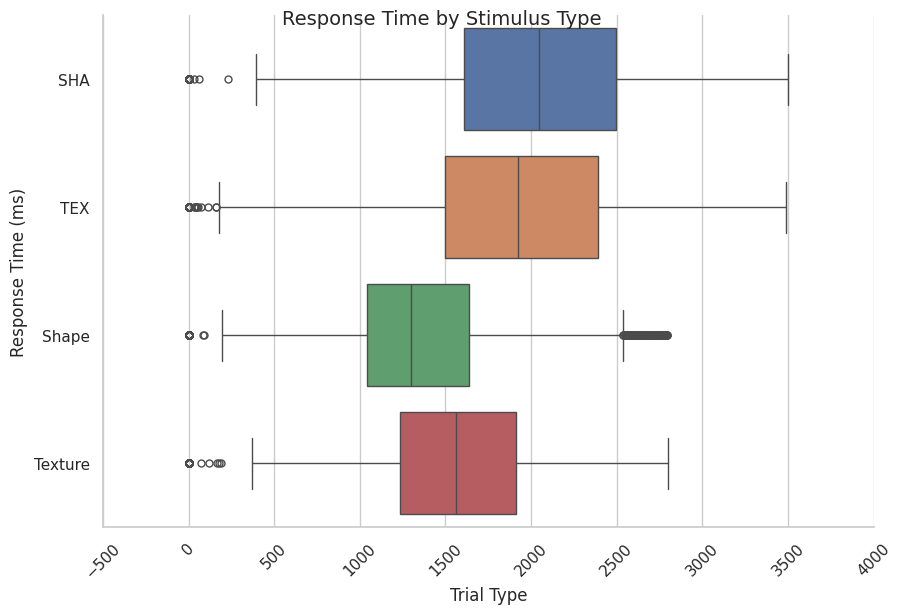

In [104]:
response_times = rel_df[rel_df['trial_type'].str.contains('stim', case=False)]

# Create the plot with facets by stim_type
g = sns.catplot(data=response_times, x="response_time", y="stim_type", hue="stim_type", kind="box", height=6, aspect=1.5)

# Label the axes
g.set_axis_labels("Trial Type", "Response Time (ms)")

# Title for the entire plot
g.fig.suptitle("Response Time by Stimulus Type", fontsize=14)

# Rotate x-axis labels if necessary
g.set_xticklabels(rotation=45)

plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-histresponsetimetype.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

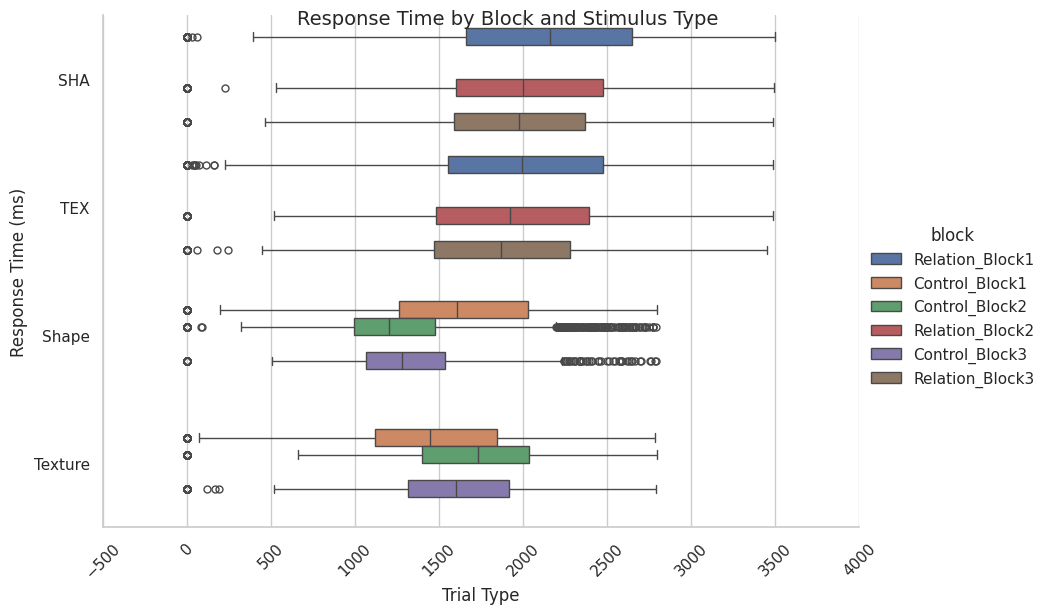

In [105]:
response_times = rel_df[rel_df['trial_type'].str.contains('stim', case=False)]

# Create the plot with facets by stim_type
g = sns.catplot(data=response_times, x="response_time", y="stim_type", hue="block", kind="box", height=6, aspect=1.5)

# Label the axes
g.set_axis_labels("Trial Type", "Response Time (ms)")

# Title for the entire plot
g.fig.suptitle("Response Time by Block and Stimulus Type", fontsize=14)

# Rotate x-axis labels if necessary
g.set_xticklabels(rotation=45)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-histresponsetimetypeblock.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Working Memory

The [Barch et al. (2013, pg 178)](https://www.sciencedirect.com/science/article/pii/S1053811913005272) highlights the Working Memory Task as:


"Recognition memory. After the participants exit the scanner from the session that includes the Working Memory tasks, they are given a “Remember, Know, New” item recognition test for the faces and places presented during the working memory task, as well as an equal number of new faces and places similar on visual characteristics (e.g., an equal number of old and new stimuli came from the same stimuli sets). We did not include body parts or tools as we did not have a sufficient number of unique stimuli to serve as “new” items. Responses to this recognition memory test can be used to segregate events to analyze the working memory trials as a function of whether the item was subsequently recognized (remember or know) or not (new), which is referred to as a subsequent memory analysis. Each item is presented for 2 s. There is then a 2 s ITI before the next stimulus. There are 48 old and 48 new stimuli (1/2 of each stimulus type). Please see the Supplemental materials for exact instructions. Data from this subsequent memory analysis will be presented in a future publication."

In [8]:
task = 'wm'
run = 'run-1'

files = sorted(Path(events_folder).rglob(f"sub-*_ses-3T_task-{task}_dir-*_{run}_events.tsv"))
combined = []
for sub_file in files:
    subject = sub_file.parts[-4]    
    out = pd.read_csv(sub_file, sep='\t')
    combined.append((subject, out))  # Append tuple of subject ID and processed dataframe
wm_df = pd.concat([df.assign(subject=subject) for subject, df in combined], ignore_index=True)
print("Rows in final Df:", len(wm_df), "for unique subjects:", len(wm_df['subject'].unique()))

Rows in final Df: 100700 for unique subjects: 1007


### Distribution of First/Last Onset Time

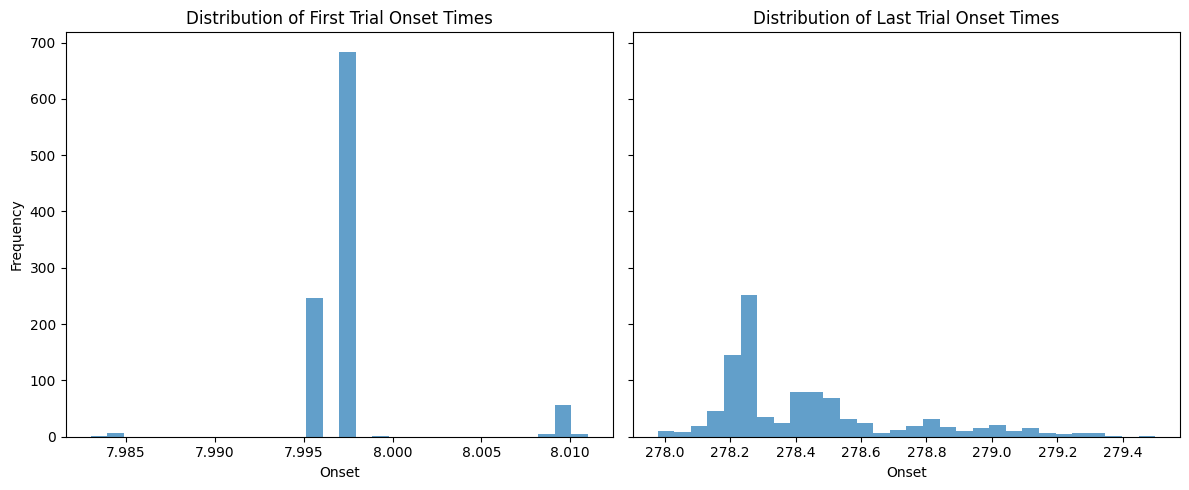

In [9]:
onset_times = wm_df.groupby("subject")["onset"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Onset Times")
axes[0].set_xlabel("Onset")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Onset Times")
axes[1].set_xlabel("Onset")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstonset.png", dpi=300, bbox_inches='tight')

plt.show()

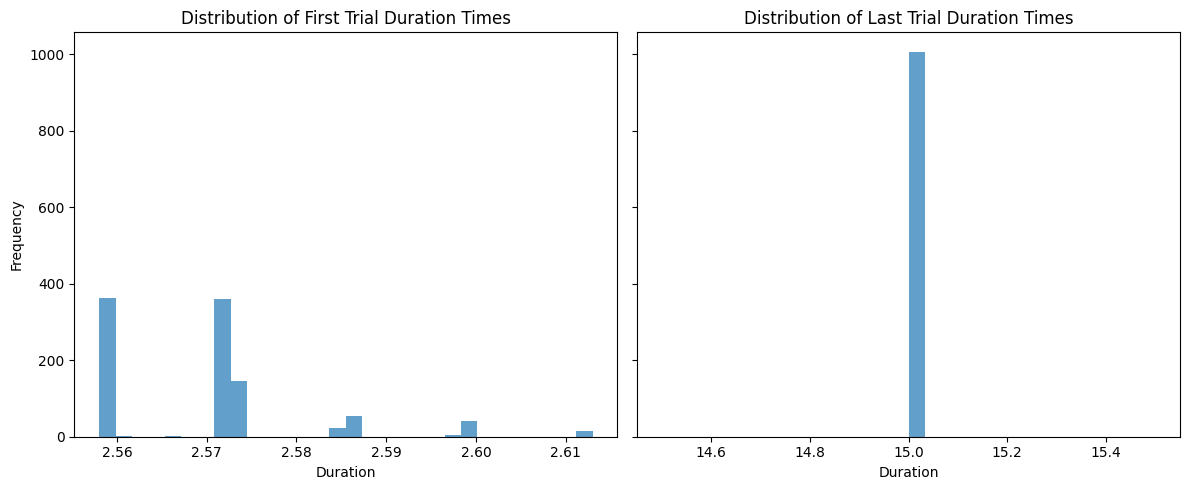

In [10]:
onset_times = wm_df.groupby("subject")["duration"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Duration Times")
axes[0].set_xlabel("Duration")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Duration Times")
axes[1].set_xlabel("Duration")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstduration.png", dpi=300, bbox_inches='tight')

plt.show()

### Distribution of Durations

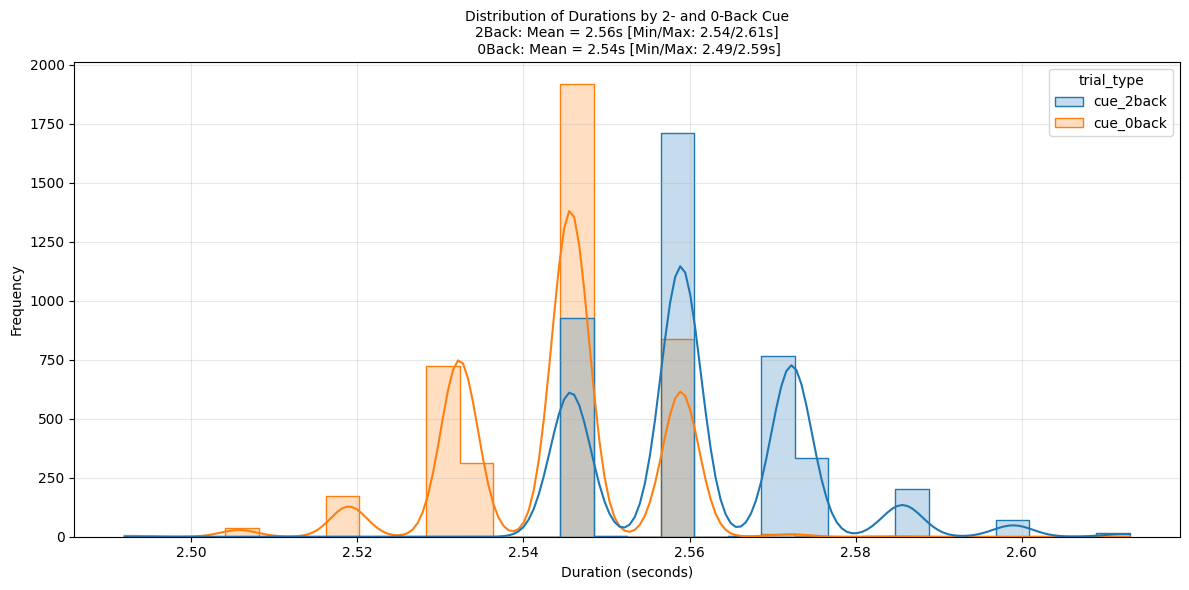

In [11]:
cueback = wm_df[wm_df['trial_type'].str.contains('cue_2back|cue_0back', case=False, na=False)]

# Compute summary statistics for each trial_type
stats = cueback.groupby('trial_type')['duration'].agg(['mean', 'min', 'max']).round(2)

# Extract values
a_mean, a_min, a_max = stats.loc['cue_2back']
b_mean, b_min, b_max = stats.loc['cue_0back']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=cueback, 
    x='duration', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations by 2- and 0-Back Cue\n"
    f"2Back: Mean = {a_mean}s [Min/Max: {a_min}/{a_max}s]\n "
    f"0Back: Mean = {b_mean}s [Min/Max: {b_min}/{b_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-cuedurations.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

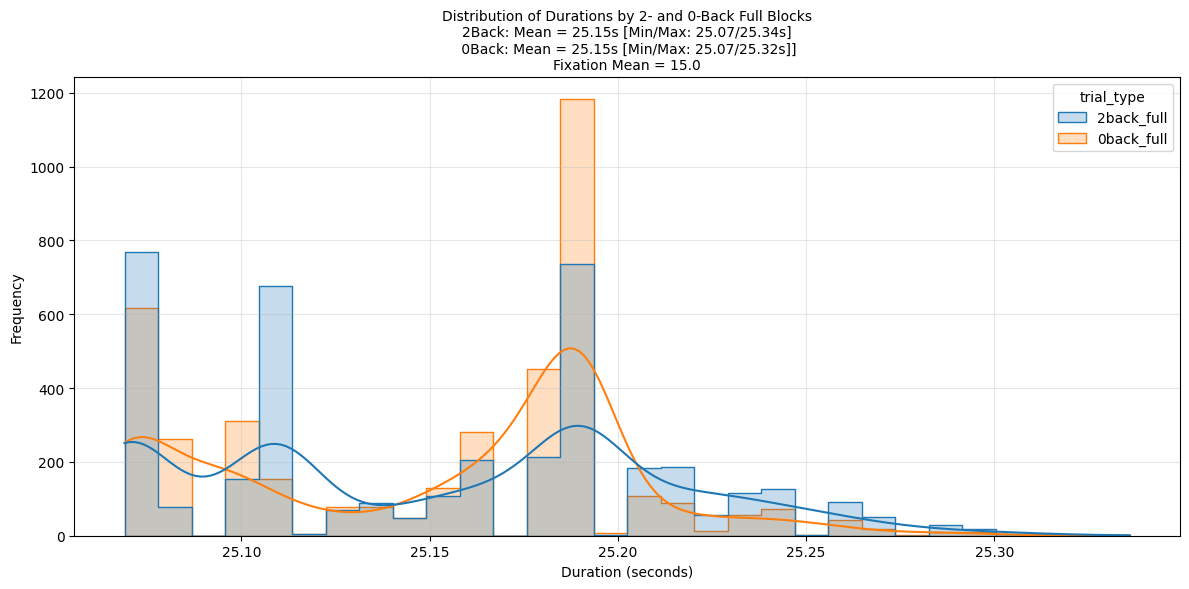

In [12]:
fullblocks = wm_df[wm_df['trial_type'].str.contains('2back_full|0back_full', case=False, na=False)]
fixblocks = wm_df[wm_df['trial_type'].str.contains('fixation', case=False, na=False)]
fix_dur = np.round(fixblocks['duration'].mean(),2)
# Compute summary statistics for each trial_type
stats = fullblocks.groupby('trial_type')['duration'].agg(['mean', 'min', 'max']).round(2)

# Extract values
a_mean, a_min, a_max = stats.loc['2back_full']
b_mean, b_min, b_max = stats.loc['0back_full']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=fullblocks, 
    x='duration', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations by 2- and 0-Back Full Blocks\n"
    f"2Back: Mean = {a_mean}s [Min/Max: {a_min}/{a_max}s]\n "
    f"0Back: Mean = {b_mean}s [Min/Max: {b_min}/{b_max}s]]\n"
    f"Fixation Mean = {fix_dur}",
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fullblockdurations.png", dpi=300, bbox_inches='tight')
plt.tight_layout()

### Response Times

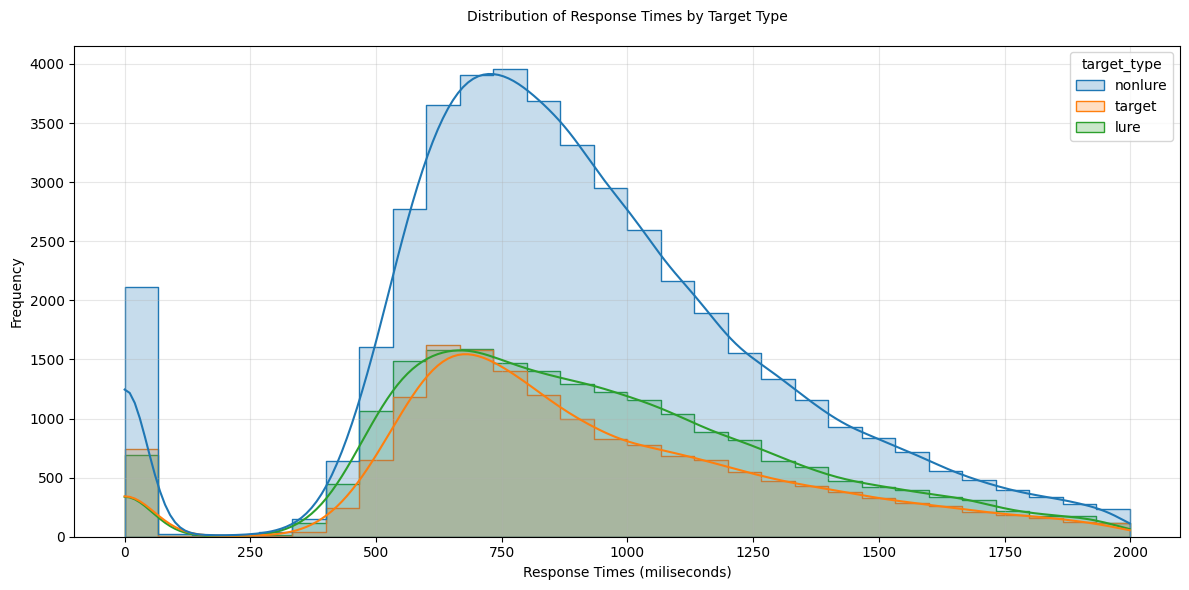

In [13]:
wmstim_response = wm_df[
    wm_df['trial_type'].str.contains('0back|2back', case=False, na=False) &  # Include '0back' or '2back'
    ~wm_df['trial_type'].str.contains('cue_|_full|fixation', case=False, na=False)  # Exclude these
]

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=wmstim_response, 
    x='response_time', 
    hue='target_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Response Times by Target Type\n",
    fontsize=10
)

# Label axes
plt.xlabel('Response Times (miliseconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-responsetimestarget.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

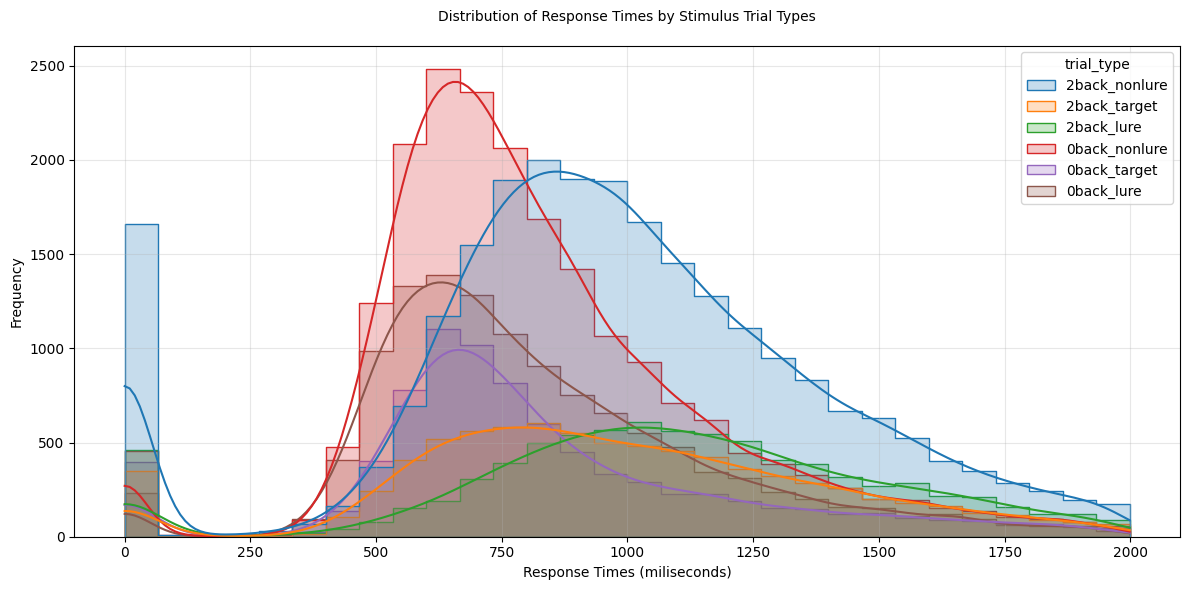

In [14]:
wmstim_response = wm_df[
    wm_df['trial_type'].str.contains('0back|2back', case=False, na=False) &  # Include '0back' or '2back'
    ~wm_df['trial_type'].str.contains('cue_|_full|fixation', case=False, na=False)  # Exclude these
]

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=wmstim_response, 
    x='response_time', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Response Times by Stimulus Trial Types\n",
    fontsize=10
)

# Label axes
plt.xlabel('Response Times (miliseconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-responsetimestargetnback.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

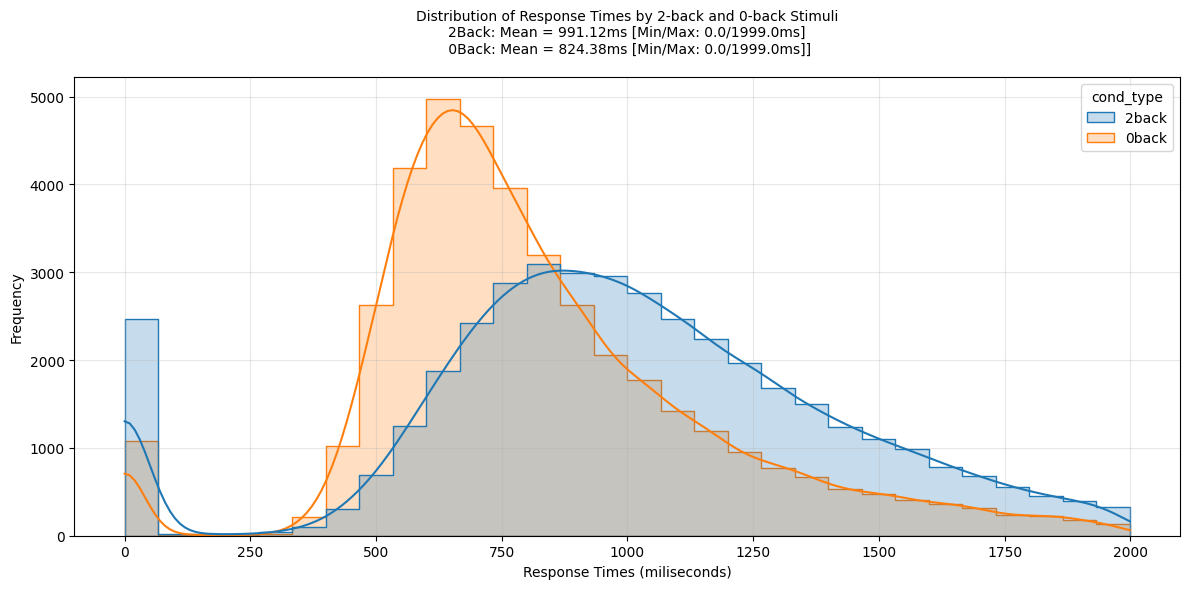

In [15]:
# Make a copy to avoid SettingWithCopyWarning
wmstim_response = wmstim_response.copy()

# Create cond_type column
wmstim_response.loc[:, 'cond_type'] = wmstim_response['trial_type'].apply(
    lambda x: '0back' if '0back' in x else ('2back' if '2back' in x else None)
)


# Compute summary statistics for each trial_type
stats = wmstim_response.groupby('cond_type')['response_time'].agg(['mean', 'min', 'max']).round(2)
# Extract values
a_mean, a_min, a_max = stats.loc['2back']
b_mean, b_min, b_max = stats.loc['0back']


# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=wmstim_response, 
    x='response_time', 
    hue='cond_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Response Times by 2-back and 0-back Stimuli\n"
    f"2Back: Mean = {a_mean}ms [Min/Max: {a_min}/{a_max}ms]\n "
    f"0Back: Mean = {b_mean}ms [Min/Max: {b_min}/{b_max}ms]]\n",
    fontsize=10
)

# Label axes
plt.xlabel('Response Times (miliseconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-responsetimesnback.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

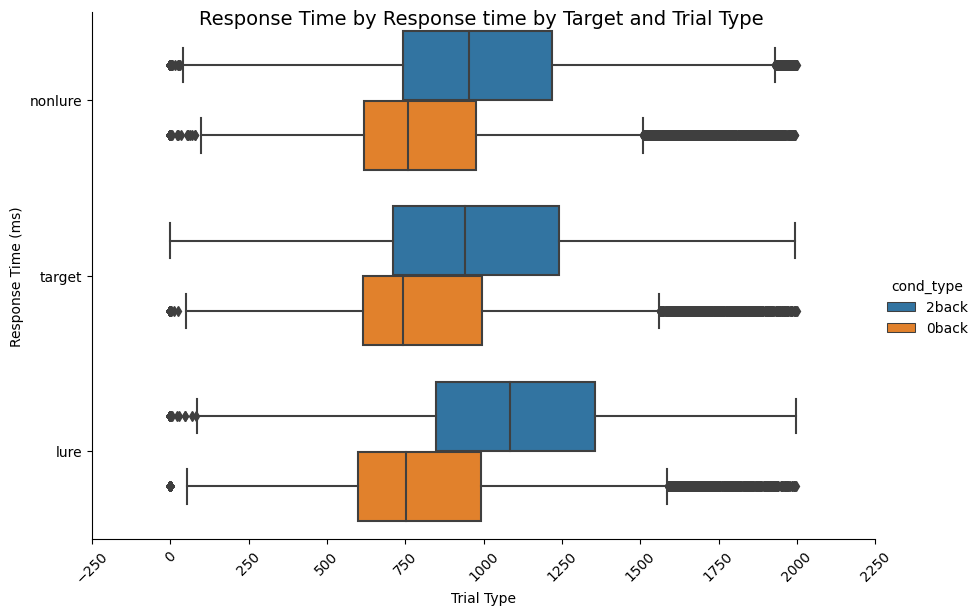

In [16]:
response_times = wmstim_response

# Create the plot with facets by stim_type
g = sns.catplot(data=response_times, x="response_time", y="target_type", hue="cond_type", kind="box", height=6, aspect=1.5)

# Label the axes
g.set_axis_labels("Trial Type", "Response Time (ms)")

# Title for the entire plot
g.fig.suptitle("Response Time by Response time by Target and Trial Type", fontsize=14)

# Rotate x-axis labels if necessary
g.set_xticklabels(rotation=45)

plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-histresponsetimestarget.png", dpi=300, bbox_inches='tight')


# Show the plot
plt.show()

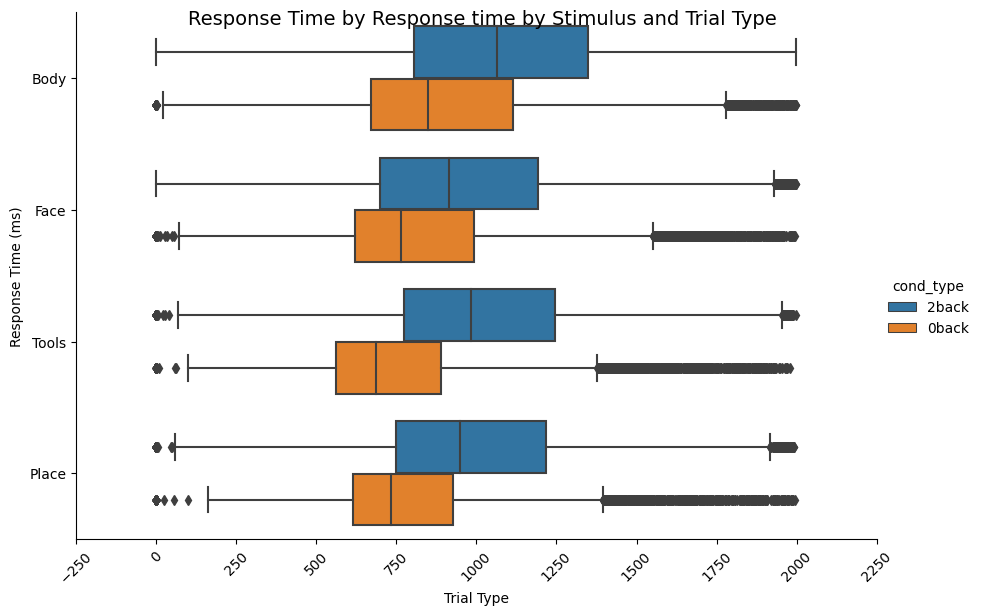

In [18]:
# Create the plot with facets by stim_type
g = sns.catplot(data=response_times, x="response_time", y="stimulus_type", hue="cond_type", kind="box", height=6, aspect=1.5)

# Label the axes
g.set_axis_labels("Trial Type", "Response Time (ms)")

# Title for the entire plot
g.fig.suptitle("Response Time by Response time by Stimulus and Trial Type", fontsize=14)

# Rotate x-axis labels if necessary
g.set_xticklabels(rotation=45)

plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-histresponsetimesstimcond.png", dpi=300, bbox_inches='tight')


# Show the plot
plt.show()